In [1]:
# Python packages and utilities
import importlib
from IPython.display import display, HTML
import logging
import numpy as np
# Ensure mlxtend is installed
import mlxtend
# Ensure Mordred is installed
try:
    import mordred
    from mordred import Calculator, descriptors
except ModuleNotFoundError:
    !pip install 'mordred[full]'
    import mordred
    from mordred import Calculator, descriptors
import os
# Ensure scikit-learn is installed
import sklearn
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV, RFE
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

import sys
# Ensure imbalanced-learn is installed
from imblearn.over_sampling import SMOTE, SMOTENC, SMOTEN

# Ensure seaborn is installed
import seaborn as sns

# Ensure matplotlib is installed
import matplotlib.pyplot as plt

# Ensure PIL is installed
from PIL import Image

# Ensure scikit-plot is installed
import scikitplot as skplt

import pandas as pd
# Ensure own module is imported correctly
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pythia import classification_metrics as cmetrics
from pythia import fingerprints_generation as fp
from pythia import molecules_and_structures as ms
from pythia import plots as pltsk
from pythia import workflow_functions as wf

# Utility configurations
%load_ext autoreload
%autoreload 2
%aimport

# Logging configuration
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)

# Set random seed
random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")


Random seed fixed as 10459


Modules to reload:
all-except-skipped

Modules to skip:



# Load target data

First we read the dataset from a csv file. A csv file is a comma separated file, where each row is a data point.

`pd.read_csv()` is used to read the input csv file that contain the dataset. The dataset is stored in a dataframe, which is a data structure provided by the pandas library. A dataframe is a two-dimensional data structure, i.e. data is aligned in a tabular fashion in rows and columns. The dataframe can be indexed by column names.

Here, we also reformat the column names to replace spaces with underscores and make the column names all lower case. This is done to make it easier to work with the data.

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)

In [3]:
data = pd.read_csv("First_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [4]:
log.info("Columns: {}".format(data.columns))

Columns: Index(['reaction', 'substrate', 'catalyst', 'solvent', 'solvent_code',
       'temperature', 'ee', 'ddg', 'paper'],
      dtype='object')


In [5]:
data

,reaction,substrate,catalyst,solvent,solvent_code,temperature,ee,ddg,paper
0,0,CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2,CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...,toluene,0,-30.0,14,0.569810,Nature 2009
1,1,C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3,CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...,toluene,0,-30.0,41,1.761325,Nature 2009
2,2,CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2,CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...,toluene,0,-30.0,30,1.251493,Nature 2009
3,3,C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3,CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...,toluene,0,-30.0,86,5.229434,Nature 2009
4,4,CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2,CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...,toluene,0,-30.0,58,2.678563,Nature 2009
...,...,...,...,...,...,...,...,...,...
114,114,C=CC/N=C(C)/C1=CC=CC=C1,CN(C([C@H](NC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1...,toluene,0,-75.0,0,0.000000,0ee - manually
115,115,CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2,[H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...,toluene,0,-30.0,0,0.000000,0ee - manually
116,116,C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3,[H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...,toluene,0,-30.0,0,0.000000,0ee - manually
117,117,C/C(C1=CC=CC=C1)=N\CC2=CC=CC=C2,[H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...,toluene,0,-75.0,0,0.000000,0ee - manually


# Set Target Properties

Here we define the input column and the target column. 

In chemistry, we usually use SMILES to represent molecules. SMILES is a string representation of a molecule. These SMILES strings should be obtained during data collection. Here we define the column name that contains the SMILES strings. 

The target values are the values that we want to predict. In this case, the target column is the column that contains the ddg values.

In [6]:
substratesmiles = data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles.head()))

catalystsmiles = data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles.head()))

reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

temp = data["temperature"]
log.info("Temperature: {}".format(temp.head()))

ddg = data["ddg"]
log.info("DGG: {}".format(ddg.head()))

Substrate SMILES: 0         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
1    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
2         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
3    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
4         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
1    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
Name: catalyst, dtype: object
Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64
Temperature: 0   -30.0
1   -30.0
2   -30.0
3   -30.0
4   -30.0
Name: temperature, dtype: float64
DGG: 0    0.569810
1    1.761325
2    1.251493
3    5.229434
4    2.678563
Name: ddg, dtype: float64


In [7]:
targets = ddg

In [8]:
os.makedirs("results_class_mordred", exist_ok=True)
os.chdir("results_class_mordred")

# Generate Mordred Descriptors as Features

We first convert the SMILES strings into RDKit molecules. RDKit is a cheminformatics software that can be used to manipulate molecules. 

Then we use the `Mordred` library to calculate the molecular descriptors. Mordred is a python library that can be used to calculate molecular descriptors. They include 1D, 2D and 3D descriptors. Examples of 1D descriptors are molecular weight, number of hydrogen bond donors, number of hydrogen bond acceptors, etc. Examples of 2D descriptors are number of rings, number of rotatable bonds, etc. Examples of 3D descriptors are molecular surface area, molecular volume, etc. Here we do not use 3D descriptors because they are computationally expensive to calculate.

Here we do the process once for the substrates and once for the catalysts. Then we conctainate the two. If you have once molecule you do not have to do this

In [9]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list = [ms.get_mol_from_smiles(s) for s in substratesmiles]
subfeatures_df = calc.pandas(submolecule_list)

100%|█████████████████████████████████████████| 119/119 [00:08<00:00, 13.99it/s]


`dataframe.dropna()` is used to remove rows with missing values. Here we remove rows with missing values in the target column with a threshold of 0.9 * number of rows. This means that if a row has more than 90% missing values, it will be removed. Then we also dropped the rows with a standard deviation that is less than 0.5. This is done to remove features that have little variance.

In [10]:
subfeatures_df.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df.index)))
threshold = 0.5
subfeatures_df.drop(subfeatures_df.std()[subfeatures_df.std() < threshold].index.values, axis=1)
subfeatures_df.columns = [ent.strip() for ent in subfeatures_df.columns]
subfeatures_df.head()

/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_2122/2554755101.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  subfeatures_df.drop(subfeatures_df.std()[subfeatures_df.std() < threshold].index.values, axis=1)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,14.538011,12.482550,0,0,23.734067,...,24,94.0,104.0,6.395833,4.180556
1,16.182576,12.923224,0,0,28.376768,...,28,104.0,118.0,4.694444,4.805556
2,14.538011,12.482550,0,0,23.734067,...,24,94.0,104.0,6.395833,4.180556
3,16.182576,12.923224,0,0,28.376768,...,28,104.0,118.0,4.694444,4.805556
4,14.538011,12.482550,0,0,23.734067,...,24,94.0,104.0,6.395833,4.180556


Then we define the types of the features. Categorial features are features that have a finite set of possible values. For example, the feature 'number of rings' can only take integer values. Continuous features are features that can take any value. For example, the feature 'molecular weight' can take any value. Here, we have both categorical and continuous features, so we choose 'some_categorical' as the type.

In [11]:
log.info(subfeatures_df)
subfeature_types = "some_categorical" # other options 'some_categorical', 'no_categorical'

           ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  \
0    14.538011  12.482550      0      0  23.734067  ...    24     94.0   
1    16.182576  12.923224      0      0  28.376768  ...    28    104.0   
2    14.538011  12.482550      0      0  23.734067  ...    24     94.0   
3    16.182576  12.923224      0      0  28.376768  ...    28    104.0   
4    14.538011  12.482550      0      0  23.734067  ...    24     94.0   
..         ...        ...    ...    ...        ...  ...   ...      ...   
114   8.554231   7.960160      0      0  15.368571  ...    13     52.0   
115  14.538011  12.482550      0      0  23.734067  ...    24     94.0   
116  16.182576  12.923224      0      0  28.376768  ...    28    104.0   
117  12.089765  10.061032      0      0  21.313564  ...    19     76.0   
118   8.554231   7.960160      0      0  15.368571  ...    13     52.0   

     Zagreb2  mZagreb1  mZagreb2  
0      104.0  6.395833  4.180556  
1      118.0  4.694444  4.805556  
2     

In [12]:
# Mordred for catalysts

In [13]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list = [ms.get_mol_from_smiles(s) for s in catalystsmiles]
catfeatures_df = calc.pandas(catmolecule_list)

100%|█████████████████████████████████████████| 119/119 [00:20<00:00,  5.85it/s]


In [14]:
catbackup_feature_df = catfeatures_df.copy()

In [15]:
catfeatures_df.dropna(inplace=True, thresh=int(0.9*len(catfeatures_df.index)))
threshold = 0.5
catfeatures_df.drop(catfeatures_df.std()[catfeatures_df.std() < threshold].index.values, axis=1)
catfeatures_df.columns = [ent.strip() for ent in catfeatures_df.columns]
catfeatures_df.head()

/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_2122/3109118302.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  catfeatures_df.drop(catfeatures_df.std()[catfeatures_df.std() < threshold].index.values, axis=1)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,...,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,21.401108,19.292802,0,0,30.867985,...,43,144.0,162.0,15.215278,5.722222
1,21.401108,19.292802,0,0,30.867985,...,43,144.0,162.0,15.215278,5.722222
2,26.241465,22.162609,0,0,39.436111,...,52,176.0,199.0,15.826389,7.055556
3,26.241465,22.162609,0,0,39.436111,...,52,176.0,199.0,15.826389,7.055556
4,26.977082,23.080194,0,0,40.925850,...,56,182.0,208.0,16.687500,7.277778


In [16]:
log.info(catfeatures_df)
catfeature_types = "some_categorical" 

           ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  \
0    21.401108  19.292802      0      0  30.867985  ...    43    144.0   
1    21.401108  19.292802      0      0  30.867985  ...    43    144.0   
2    26.241465  22.162609      0      0  39.436111  ...    52    176.0   
3    26.241465  22.162609      0      0  39.436111  ...    52    176.0   
4    26.977082  23.080194      0      0  40.925850  ...    56    182.0   
..         ...        ...    ...    ...        ...  ...   ...      ...   
114  21.401108  19.292802      0      0  30.867985  ...    43    144.0   
115  16.714811  14.859531      0      0  24.619317  ...    30    110.0   
116  16.714811  14.859531      0      0  24.619317  ...    30    110.0   
117  16.714811  14.859531      0      0  24.619317  ...    30    110.0   
118  16.714811  14.859531      0      0  24.619317  ...    30    110.0   

     Zagreb2   mZagreb1  mZagreb2  
0      162.0  15.215278  5.722222  
1      162.0  15.215278  5.722222  
2  


# Pearson correlation coefficent and Spearman's rank correlation coefficient
In the next cells we can investigate how well each bit correlates against our property of interest and checks for signficance using a one tail permutation test: how many times out of the n_sample do I obtain a correlation coefficient that is greater than the observed value.


In the next block the feature with a reasonable correlation and statistically significant are chosen. The `sig_metric` is the significance testing metric correlation coefficent names are two tail p tests. to do one tail enter replacing option with `gt` for greater than and `lt` for less than and the correction coefficent name one of `pearsron`, `spearman` or `kendalltau`, `onetail_$option_$correlation_coefficent`.

If you don't how to choose between pearson, spearman or kendalltau, please have a read in the literature as this will depend on the type of data you have. Usually pearson is used for continuous data whereas spearman for discrete

In [17]:
subreasonable_predicted_properties, subsignificant_fearures = wf.find_correlating_features(subfeatures_df, targets, thresh=0.36, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0      0.569810
1      1.761325
2      1.251493
3      5.229434
4      2.678563
         ...   
114    0.000000
115    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: ddg, Length: 119, dtype: float64
Significance will be calculated for the correlations
GATS3c: -0.4557 P: 0.0002 Significant at 0.0500 level? True
GATS3se: -0.4813 P: 0.0002 Significant at 0.0500 level? True
GATS3pe: -0.4114 P: 0.0002 Significant at 0.0500 level? True
GATS3are: -0.4403 P: 0.0002 Significant at 0.0500 level? True
Lipinski: -0.3776 P: 0.0002 Significant at 0.0500 level? True
GGI9: 0.3728 P: 0.0002 Significant at 0.0500 level? True


In [18]:
log.info("{} {}".format(subreasonable_predicted_properties, len(subreasonable_predicted_properties)))
log.info("{} {}".format(subsignificant_fearures, len(subsignificant_fearures)))
use_significant = True
use_reasonable = False

['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9'] 6
['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9'] 6


In [19]:
catreasonable_predicted_properties, catsignificant_fearures = wf.find_correlating_features(catfeatures_df, targets, thresh=0.55, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0      0.569810
1      1.761325
2      1.251493
3      5.229434
4      2.678563
         ...   
114    0.000000
115    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: ddg, Length: 119, dtype: float64
Significance will be calculated for the correlations
VE3_A: 0.6258 P: 0.0002 Significant at 0.0500 level? True
ATS5d: 0.5680 P: 0.0002 Significant at 0.0500 level? True
ATS6d: 0.5664 P: 0.0002 Significant at 0.0500 level? True
ATS7d: 0.5520 P: 0.0002 Significant at 0.0500 level? True
ATS7s: 0.5615 P: 0.0002 Significant at 0.0500 level? True
ATS4Z: 0.5700 P: 0.0002 Significant at 0.0500 level? True
ATS5Z: 0.6387 P: 0.0002 Significant at 0.0500 level? True
ATS6Z: 0.5565 P: 0.0002 Significant at 0.0500 level? True
ATS4m: 0.5725 P: 0.0002 Significant at 0.0500 level? True
ATS5m: 0.6029 P: 0.0002 Significant at 0.0500 level? True
ATS5v: 0.6275 P: 0.0002 Significant at 0.0500 level? True
ATS6v: 0.6314 P: 0.0002 Significant at 0.0500 level? True
ATS7v: 0.5612 P: 0.0002 Significant 

In [20]:
log.info("{} {}".format(catreasonable_predicted_properties, len(catreasonable_predicted_properties)))
log.info("{} {}".format(catsignificant_fearures, len(catsignificant_fearures)))
use_significant = True
use_reasonable = False

['VE3_A', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS7s', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS4m', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS6se', 'ATS7se', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS5are', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC6v', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c', 'AATSC6c', 'AATSC1Z', 'AATSC1m', 'MATS6c', 'MATS1se', 'MATS1pe', 'MATS1are', 'GATS7p', 'Xpc-6dv', 'SaaCH', 'MAXaaCH', 'PEOE_VSA6', 'MDEC-22', 'nRot', 'GGI3', 'GGI6', 'GGI8'] 49
['VE3_A', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS7s', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS4m', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS6se', 'ATS7se', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS5are', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC6v', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c', 'AATSC6c', 'AATSC1Z', 'AATSC1m', 'MATS6c', 'MATS1se', 'MATS1pe', 'MATS1are', 'GATS7p', 'Xpc-6dv', 'SaaCH', 'MAXaaCH', 'PEOE_VSA6', 'MDEC-22', 'nRot', 'GGI3', 'GGI6', 'GGI8'] 49


In [21]:
subfeats_df = pd.DataFrame()

if use_significant is True:
    for k in subsignificant_fearures:
        subfeats_df[k] = subfeatures_df[k]
        
elif use_reasonable is True:
    for k in subreasonable_predicted_properties:
        subfeats_df[k] = subfeatures_df[k]

In [22]:
catfeats_df = pd.DataFrame()

if use_significant is True:
    for k in catsignificant_fearures:
        catfeats_df[k] = catfeatures_df[k]
        
elif use_reasonable is True:
    for k in catreasonable_predicted_properties:
        catfeats_df[k] = catfeatures_df[k]

In [23]:
features_df = subfeats_df.join(catfeats_df, lsuffix="subfeats_df", rsuffix="catfeats_df")

Dont forget to add the temperature

In [24]:
features_df = features_df.join(temp)

In [25]:
features_df

,GATS3c,GATS3se,GATS3pe,GATS3are,Lipinski,...,nRot,GGI3,GGI6,GGI8,temperature
0,1.101164,1.187627,1.169919,1.166806,True,...,3,3.0625,0.835102,0.440665,-30.0
1,0.981164,1.031415,0.978073,0.989808,True,...,3,3.0625,0.835102,0.440665,-30.0
2,1.101164,1.187627,1.169919,1.166806,True,...,5,3.3750,1.161633,0.564122,-30.0
3,0.981164,1.031415,0.978073,0.989808,True,...,5,3.3750,1.161633,0.564122,-30.0
4,1.101164,1.187627,1.169919,1.166806,True,...,5,3.7500,1.243265,0.613505,-30.0
...,...,...,...,...,...,...,...,...,...,...,...
114,1.306779,1.612830,1.359694,1.462054,True,...,3,3.0625,0.835102,0.440665,-75.0
115,1.101164,1.187627,1.169919,1.166806,True,...,3,1.8125,0.671837,0.201814,-30.0
116,0.981164,1.031415,0.978073,0.989808,True,...,3,1.8125,0.671837,0.201814,-30.0
117,1.250566,1.431267,1.258747,1.323399,True,...,3,1.8125,0.671837,0.201814,-75.0


# Classify Molecules
We use these next cells to classify the ddg values into 'good' and 'bad' in terms of ddg kJ/mol. Because the ddg values are continuous, we need to define a threshold value to separate the 'good' and 'bad' molecules. Here we define the threshold value as 4. If the target value is lower than the threshold value, we assign the class label 'class 0', which means the molecule is 'bad'. If the target value is higher than the threshold value or absent, we assign the class label 'class 1', which means the molecule is 'good'.

Note that how to define the class labels depends on the problem. For example, if we want to predict whether a molecule is toxic or not, we can define a threshold value and assign the class labels accordingly. 

In [26]:
classes=[]
for index, value in ddg.items():
    if value < 4:
        classes.append(0)
    else:
        classes.append(1)

In [27]:
classes
class_targets_df = pd.DataFrame(np.array([classes]).T, columns=["classes"])
features_and_classes_df = features_df.copy()
features_and_classes_df["classes"] = classes

# Feature exploration
In the section we explore the features and their relationships. 
We classify the ddg into 'good' and 'bad'. To visualize all of these structure set show to True.

In [28]:
pd.set_option('display.max_columns', len(features_df.columns))
features_df.describe()

,GATS3c,GATS3se,GATS3pe,GATS3are,GGI9,VE3_A,ATS5d,ATS6d,ATS7d,ATS7s,ATS4Z,ATS5Z,ATS6Z,ATS4m,ATS5m,ATS5v,ATS6v,ATS7v,ATS6se,ATS7se,ATS5pe,ATS6pe,ATS7pe,ATS5are,ATS6are,ATS7are,ATS5p,ATS6p,ATS7p,ATS6i,ATS7i,AATS8i,ATSC6v,ATSC3se,ATSC3pe,ATSC3are,AATSC0c,AATSC6c,AATSC1Z,AATSC1m,MATS6c,MATS1se,MATS1pe,MATS1are,GATS7p,Xpc-6dv,SaaCH,MAXaaCH,PEOE_VSA6,MDEC-22,nRot,GGI3,GGI6,GGI8,temperature
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,1.039625,1.127619,1.088098,1.100294,0.033046,2.897151,536.882353,523.478992,554.899160,630.026131,3471.537815,3842.361345,3715.890756,12488.175759,14164.961465,35412.432235,36189.119287,35702.967284,1641.107280,1660.058729,1250.463048,1341.036294,1326.471286,1237.767511,1328.488277,1309.008755,257.884699,273.908619,273.422388,34015.128480,35869.950075,159.871128,-1665.188956,0.043871,0.102985,0.306503,0.019147,-0.003582,0.054204,0.286466,-0.177079,-0.040930,-0.023208,-0.030310,1.130203,4.970065,13.886854,1.708270,67.826701,11.596235,6.000000,3.614437,1.352735,0.644342,-50.025210
std,0.153986,0.223764,0.172929,0.192380,0.050833,0.239249,144.369240,164.992391,197.522125,169.914130,598.243386,645.025472,685.001507,1990.934466,2291.173746,8706.076715,9849.134963,11810.145789,398.391850,535.679456,322.477145,309.113867,422.354062,317.674376,300.542924,416.128640,70.266693,80.424848,92.649382,8378.227061,11755.222620,5.559919,887.426886,0.399995,0.478259,0.558285,0.005495,0.002061,0.161900,0.732519,0.045944,0.017425,0.022040,0.020155,0.332431,1.247280,7.340658,0.541311,28.281442,5.197238,1.952834,0.570106,0.326128,0.159685,21.780672
min,0.751475,0.497034,0.510248,0.500853,0.000000,2.138716,168.000000,131.000000,107.000000,266.157407,1741.000000,1992.000000,1927.000000,6629.195433,7945.773694,11967.479765,10656.801016,8232.423459,567.809490,357.483924,416.573800,498.050600,302.880100,416.130700,506.498000,301.308000,73.748680,65.160487,51.249017,11410.024884,7002.700761,153.968435,-2432.806131,-1.562365,-1.667989,-1.940117,0.010528,-0.011493,-0.570239,-2.496364,-0.299408,-0.116996,-0.110562,-0.114267,0.785140,1.219849,0.577515,0.232639,0.000000,1.500000,2.000000,1.812500,0.671837,0.201814,-78.000000
25%,0.955798,1.018107,0.978073,0.989808,0.000000,2.817286,463.000000,420.000000,427.000000,509.504630,3036.500000,3488.000000,3415.000000,11136.954848,13035.651149,31180.594742,30949.042524,28625.053813,1493.323210,1416.097368,1123.982950,1215.578800,1128.258600,1105.890800,1201.261000,1113.804000,224.806318,234.013724,223.752439,31096.965467,30959.251213,156.496072,-2255.859327,-0.078909,-0.248520,0.085756,0.016619,-0.003372,0.040913,0.202349,-0.191752,-0.041665,-0.023967,-0.028745,0.951299,4.739793,10.349375,1.867097,51.103047,7.175546,5.000000,3.343750,1.068163,0.545100,-75.000000
50%,1.023688,1.136662,1.089701,1.104697,0.013117,3.011422,579.000000,564.000000,585.000000,684.469136,3806.000000,3891.000000,3717.000000,13204.939401,13986.347236,39537.363935,41046.436724,38521.877137,1830.262018,1780.464856,1295.283300,1509.697100,1422.354100,1281.143700,1498.140000,1402.462000,280.603473,307.741429,296.512142,37705.902670,38559.737181,157.878523,-2150.644047,0.239152,0.132033,0.391134,0.017752,-0.003077,0.070544,0.355530,-0.189573,-0.041338,-0.021184,-0.026446,1.090441,5.480270,13.204856,1.887930,81.434882,12.645308,6.000000,3.812500,1.592653,0.736961,-30.000000
75%,1.101164,1.187627,1.169919,1.166806,0.045000,3.064137,669.000000,680.000000,761.000000,738

plot a correlation matrix showing multicolliniarity between the features.

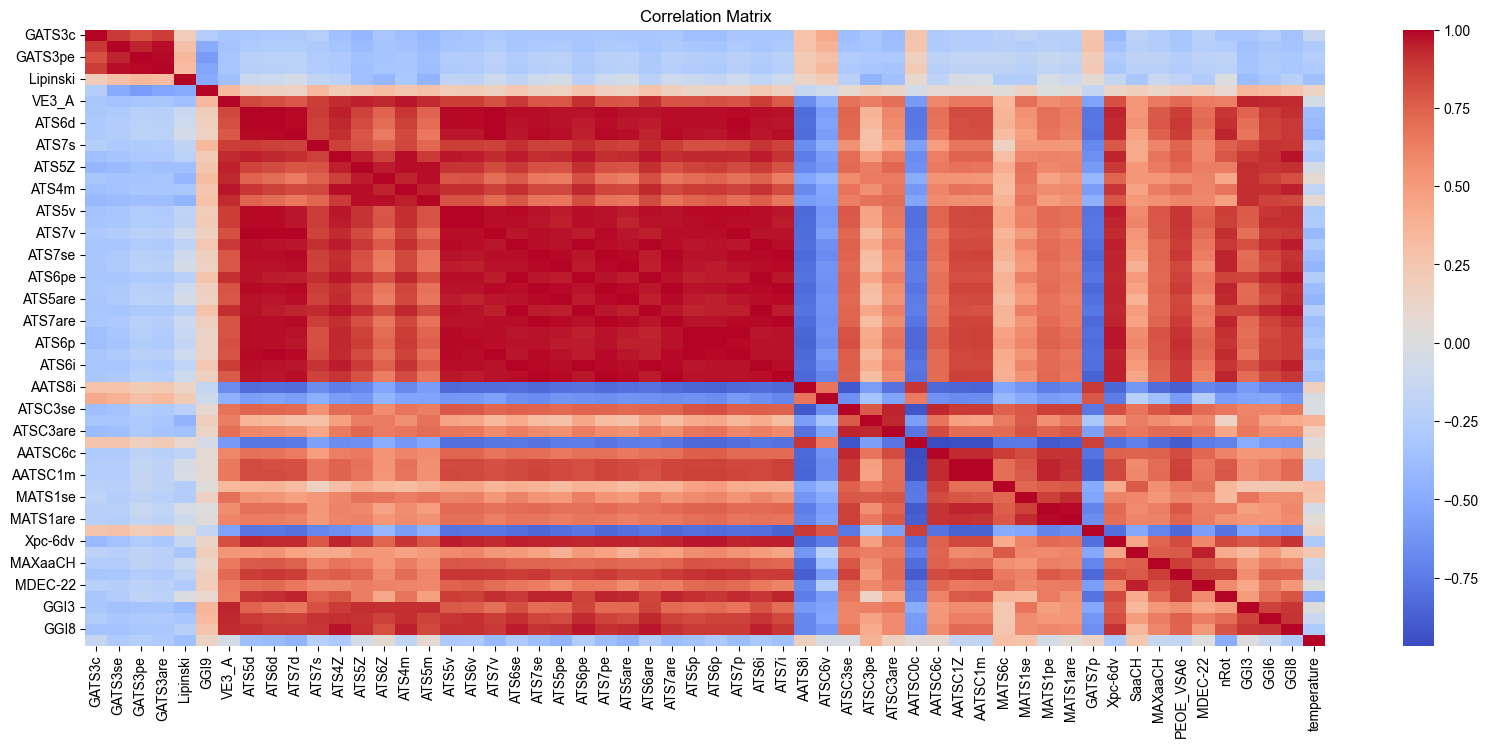

In [29]:
corr_matrix = features_df.corr()

# Create a heatmap visualization of the correlation matrix
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix")
plt.show()

Performing Variance Inflation Factor (VIF) test. It has been commented out here as for our dataset there is high multicolliniarity and actually all features should be removed. It might however be useful for your data so please go ahead and read here https://en.wikipedia.org/wiki/Variance_inflation_factor this will allow you to decide what is best for your project

In [30]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # Calculate VIF for each predictor variable
# vif_df = pd.DataFrame()
# vif_df["feature"] = features_df.columns
# vif_df["VIF"] = [variance_inflation_factor(features_df.values, i) for i in range(features_df.shape[1])]

# # Print the VIF values
# print(vif_df)

# # Remove any predictor variables with high VIF values
# # Change threshold approprietly
# vif_threshold = 10
# high_vif_features = vif_df[vif_df["VIF"] > vif_threshold]["feature"].values
# if len(high_vif_features) > 0:
#     print("Removing high VIF features:", high_vif_features)
#     features_df.drop(high_vif_features, axis=1, inplace=True)


The code generates histograms of the features in the "features_df" dataframe, and separates the histograms based on the class labels in the "classes" column of the "features_and_classes_df" dataframe.

Over all classes


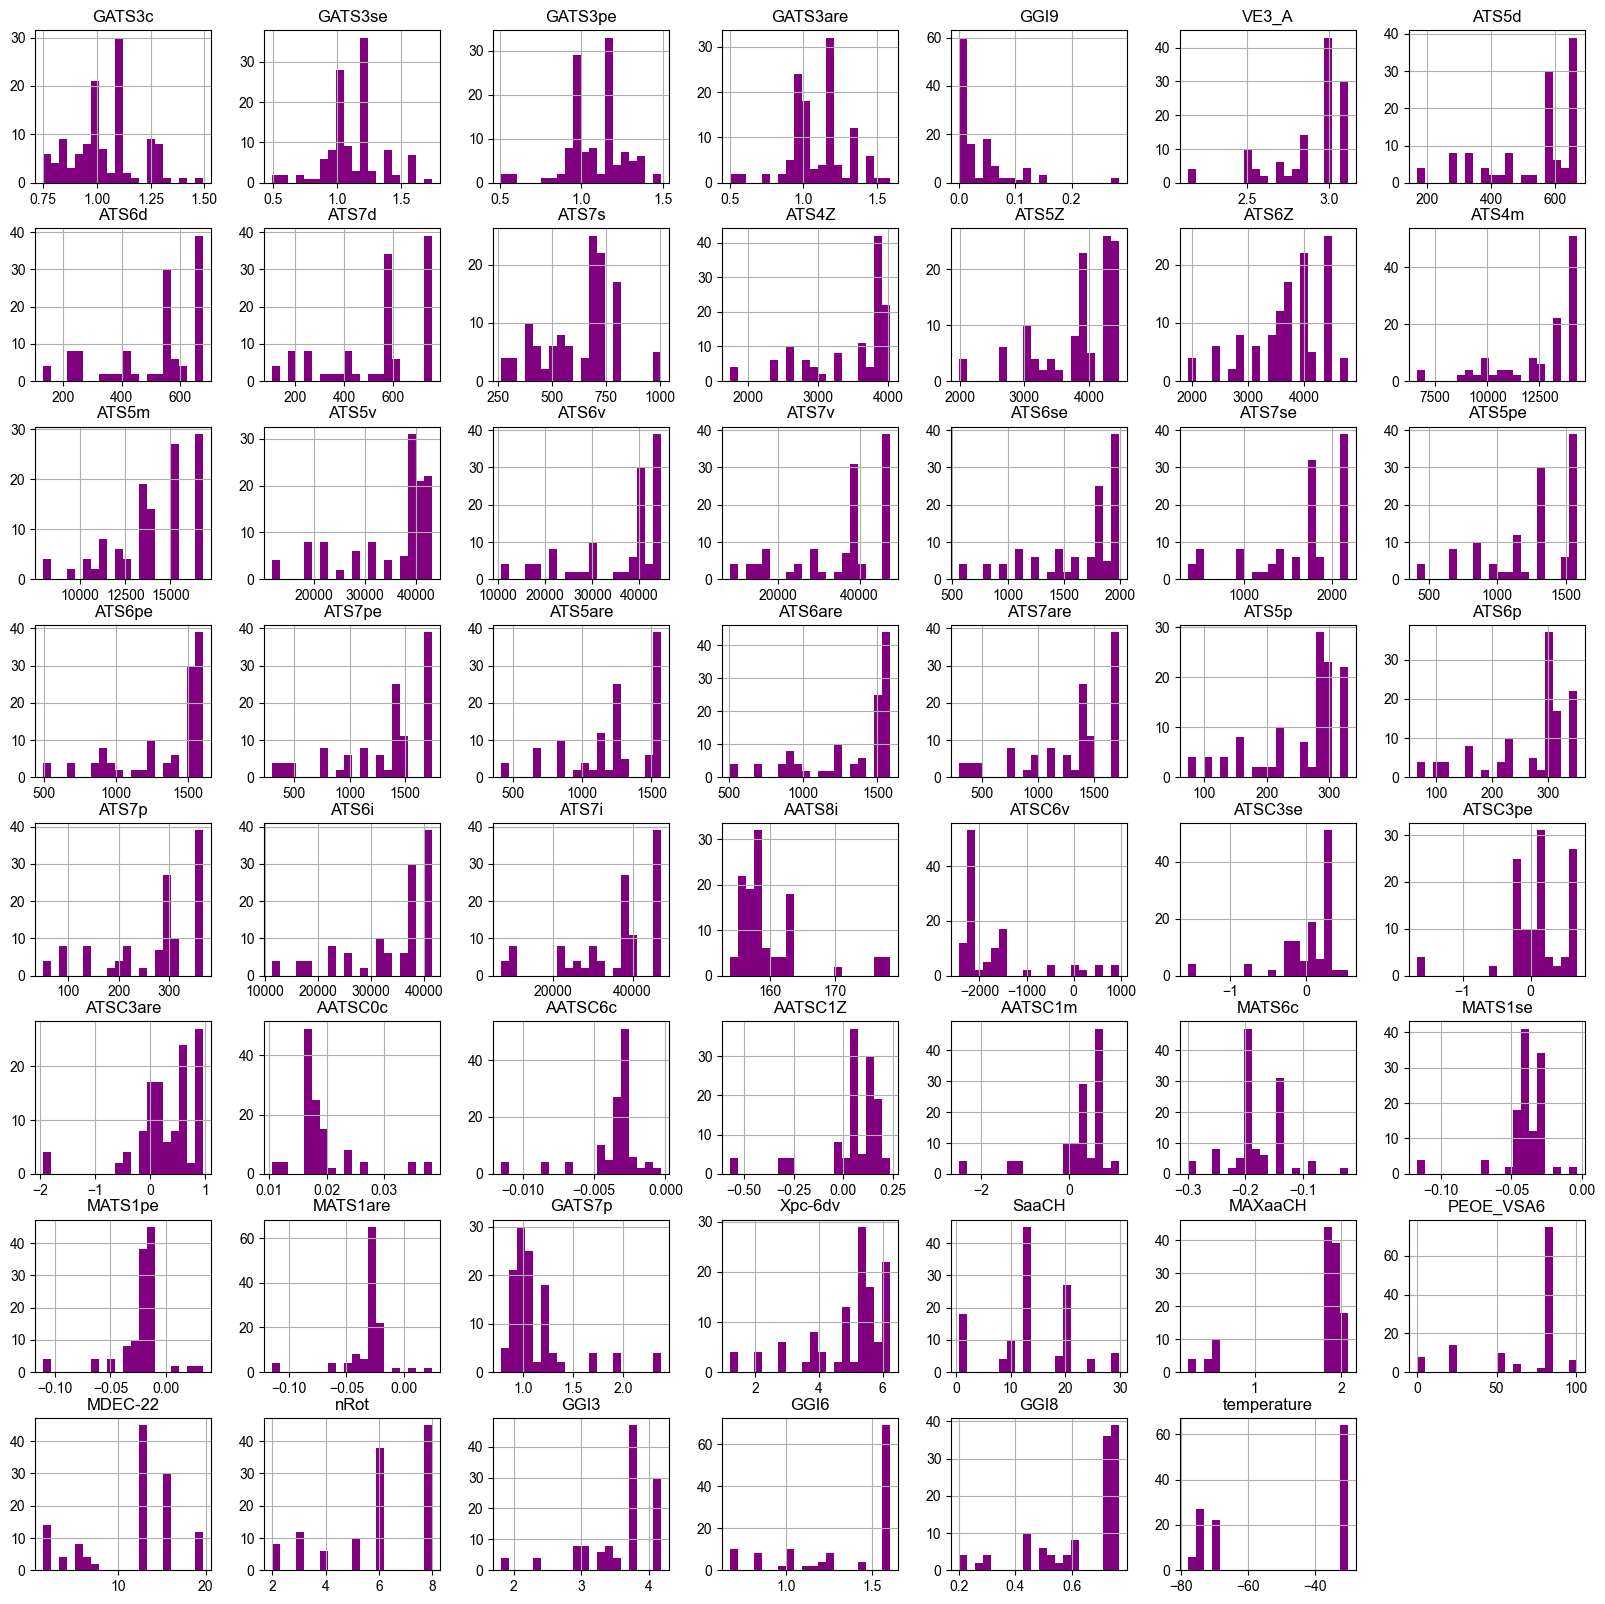

Class 0 only


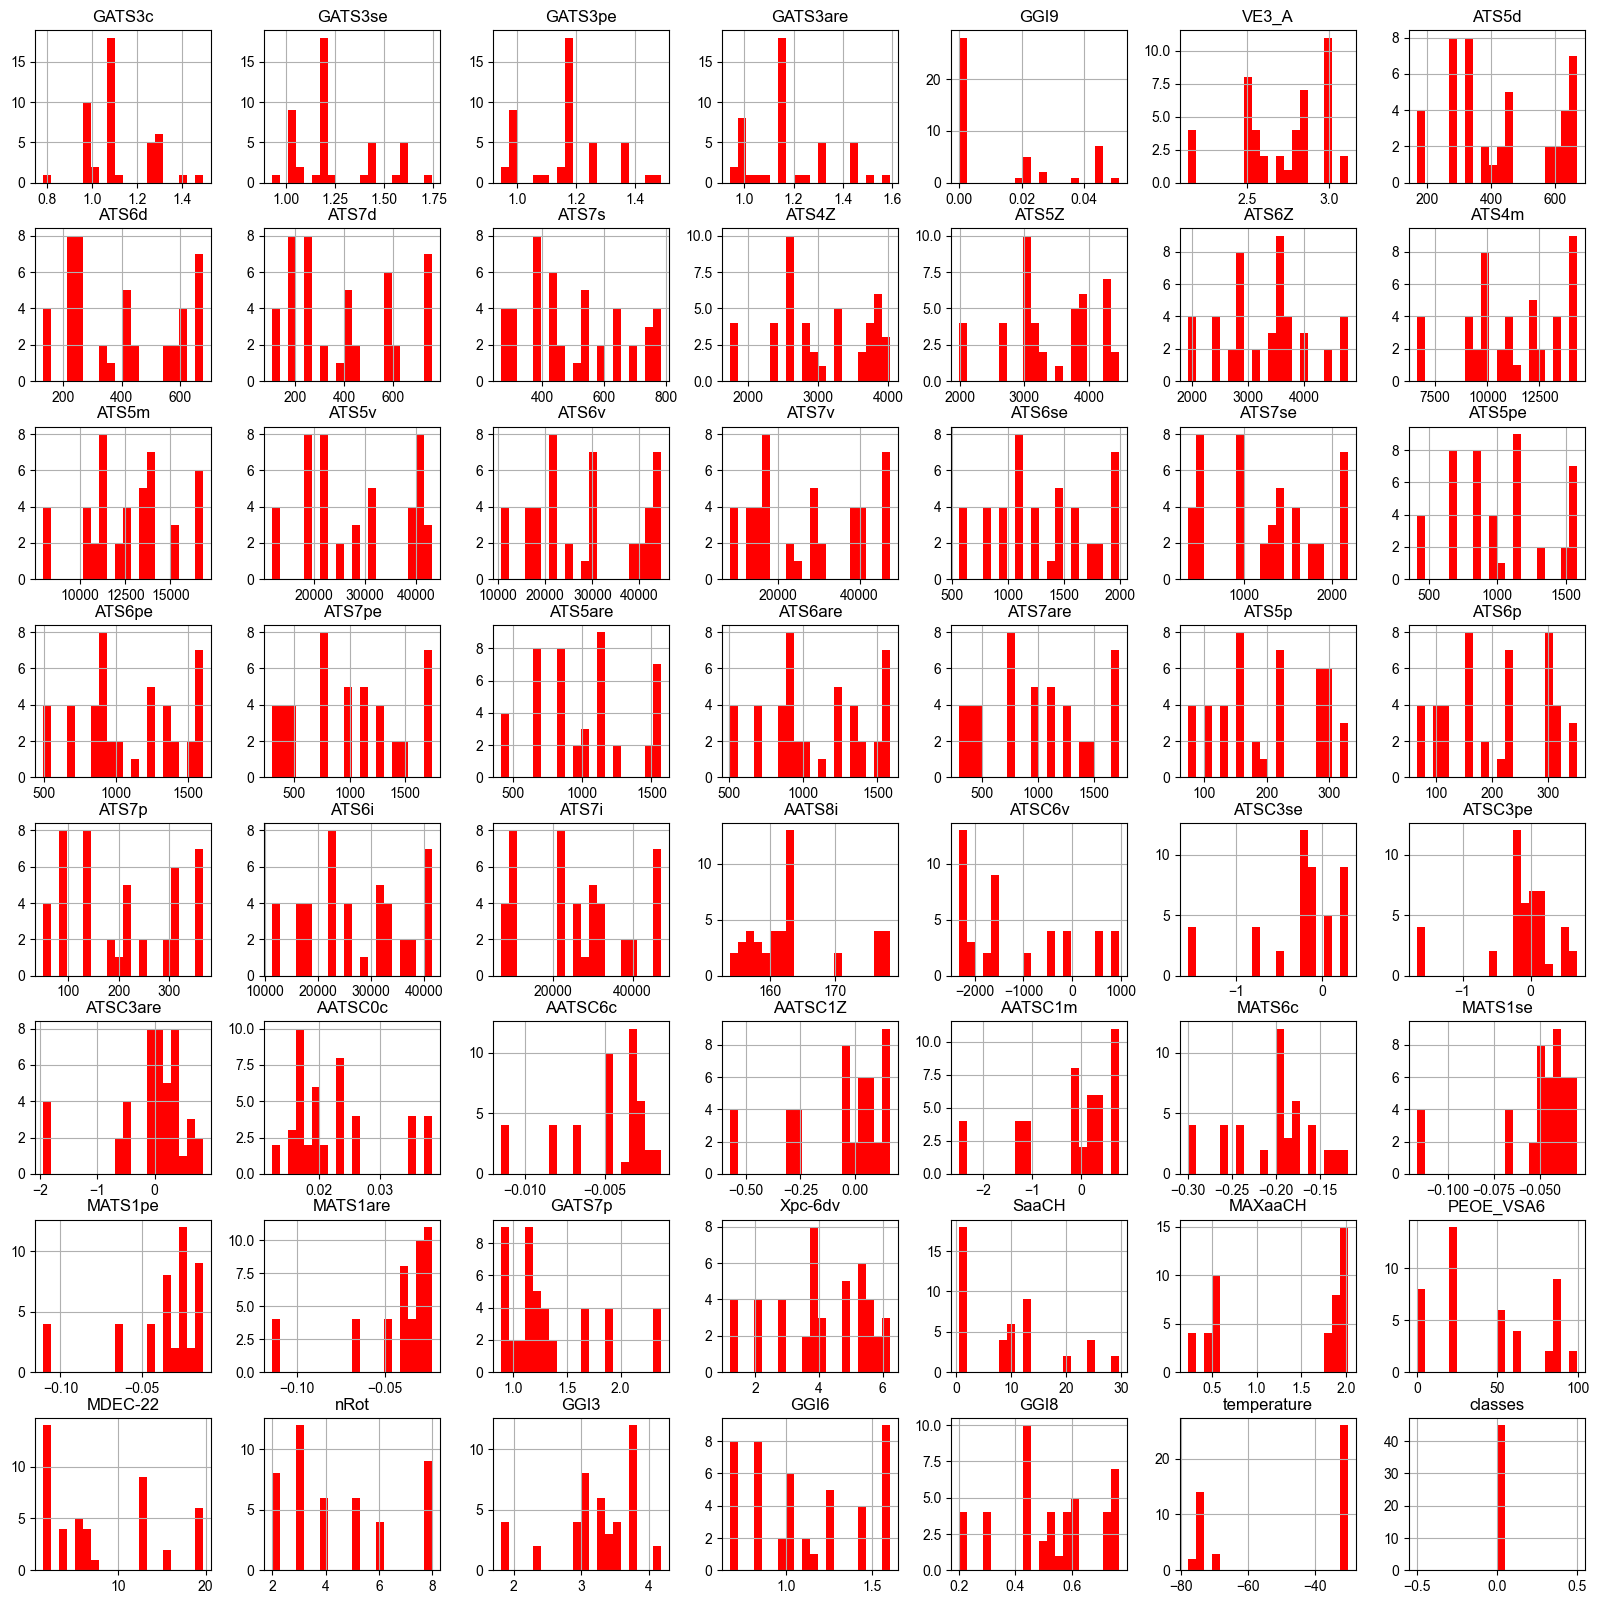

Class 1 only


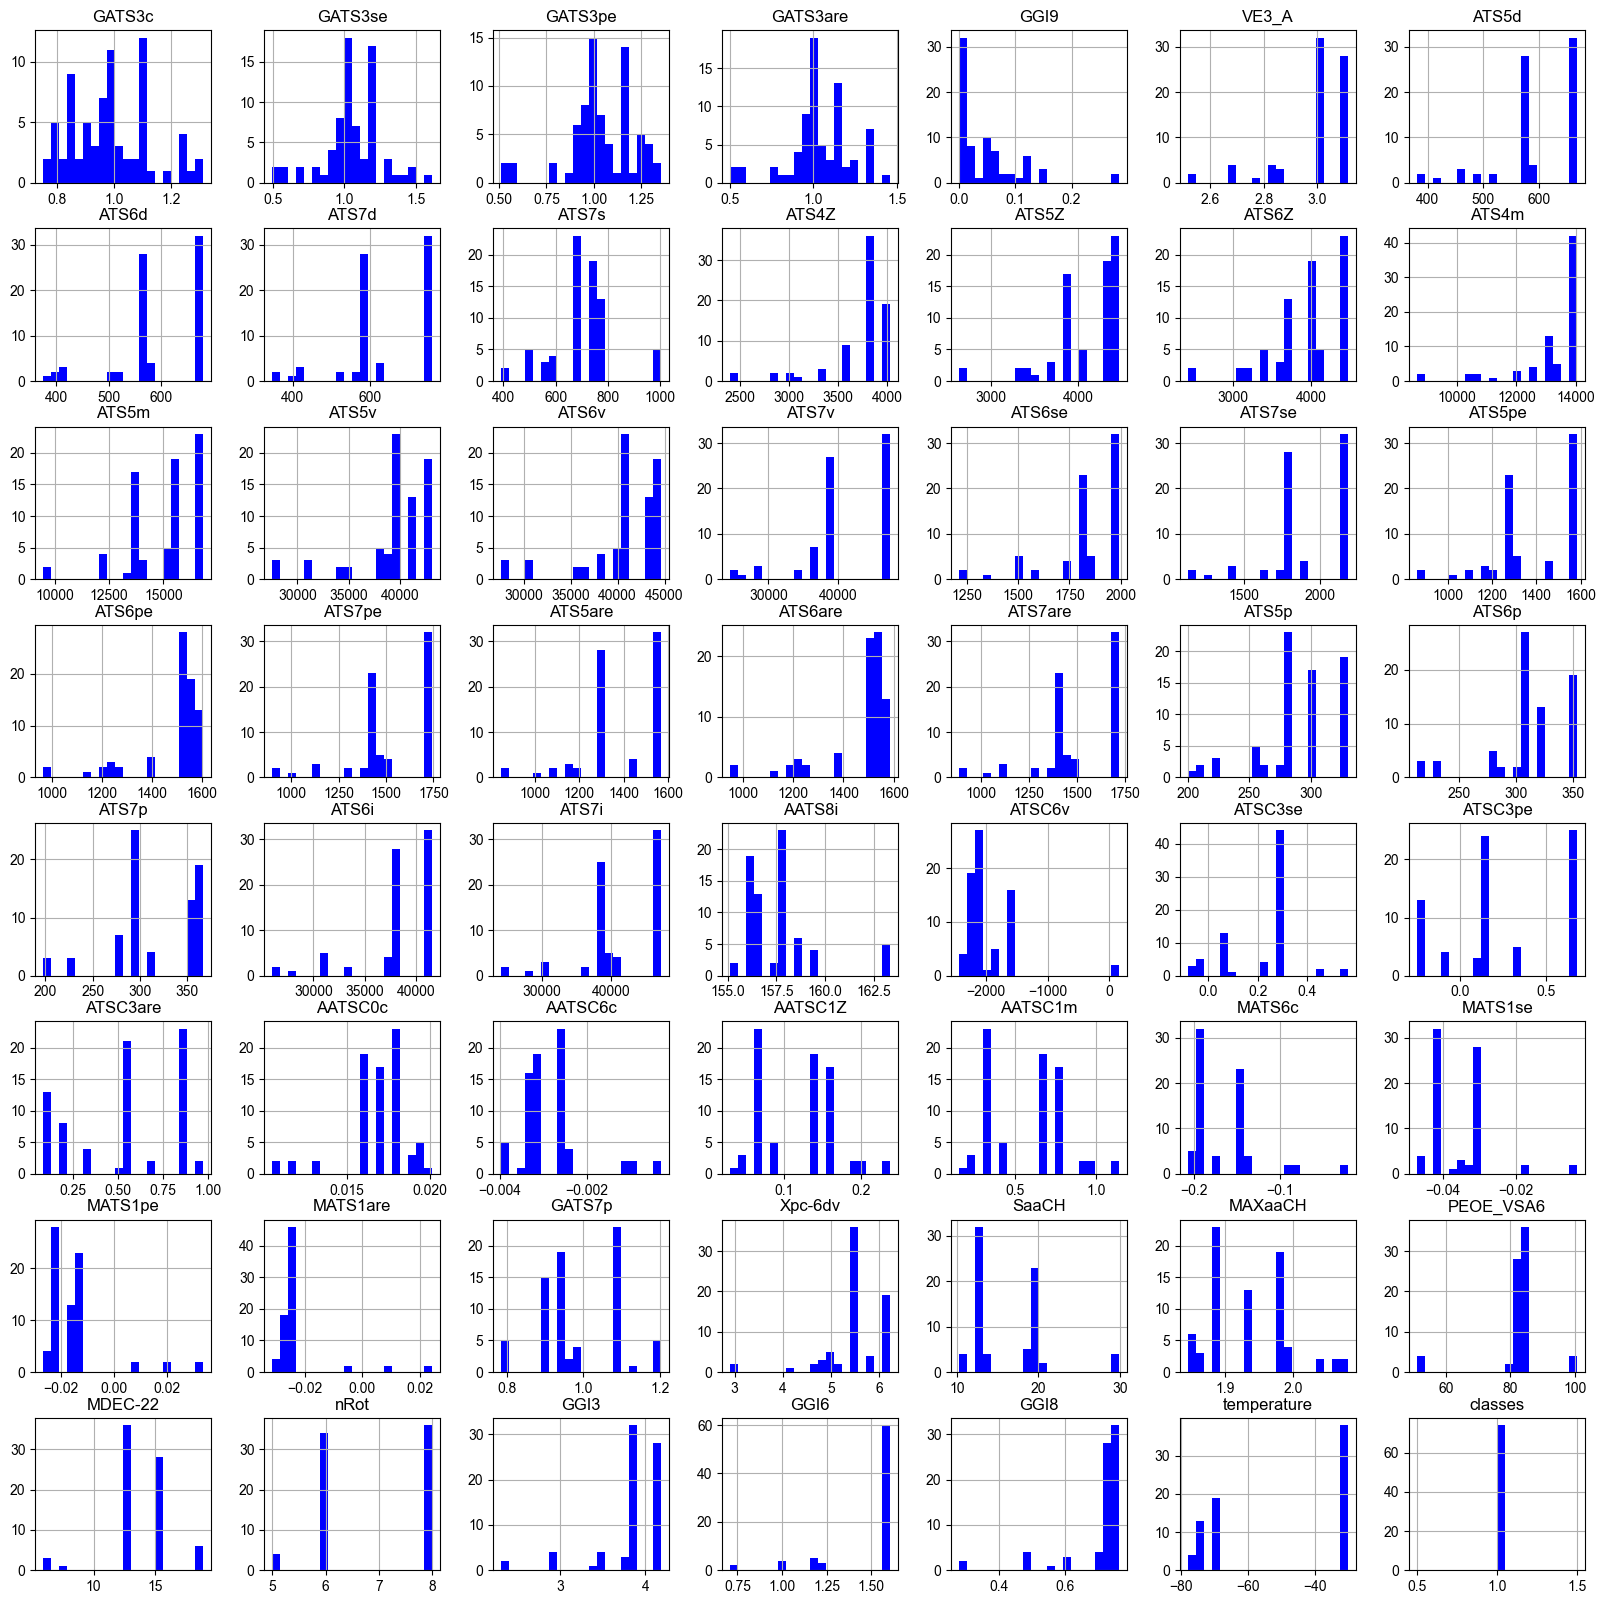

In [31]:
log.info("Over all classes")
features_df.hist(bins=20, figsize=(20,20), color="purple")
plt.savefig("features_all_classes.png")
plt.show()

log.info("Class 0 only")
features_and_classes_df[features_and_classes_df["classes"]==0].hist(bins=20, figsize=(20,20), color="red")
plt.savefig("features_class_0.png")
plt.show()

log.info("Class 1 only")
features_and_classes_df[features_and_classes_df["classes"]==1].hist(bins=20, figsize=(20,20), color="blue")
plt.savefig("features_class_1.png")
plt.show()

In [32]:
class_targets_df["classes"].values

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [33]:
# Remove features with "drop" as you see fit according to your model.

In [34]:
features_df.to_csv("features.csv")

# Classification
In this section we test out a range of classification models.

## Data scalling

Different types of features (continous or not) need different types of scalling!! we only have non categorical features, but please check yours!

In [35]:
features_df,categorical_indxs = wf.feature_categorization(features_df, feature_types = "some_categorical")

-----
Categorical features not provided. Trying to guess the categorical features automatically.
-----
Automatically assigned categorical indices:
[] 0
Automatically assigned categorical features:
[] 0
**Please check if the automatic assignment is correct. If not, please provide the indices of the categorical features.**
-----
Index(['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9', 'VE3_A',
       'ATS5d', 'ATS6d', 'ATS7d', 'ATS7s', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS4m',
       'ATS5m', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS6se', 'ATS7se', 'ATS5pe',
       'ATS6pe', 'ATS7pe', 'ATS5are', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p',
       'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC6v', 'ATSC3se', 'ATSC3pe',
       'ATSC3are', 'AATSC0c', 'AATSC6c', 'AATSC1Z', 'AATSC1m', 'MATS6c',
       'MATS1se', 'MATS1pe', 'MATS1are', 'GATS7p', 'Xpc-6dv', 'SaaCH',
       'MAXaaCH', 'PEOE_VSA6', 'MDEC-22', 'nRot', 'GGI3', 'GGI6', 'GGI8',
       'temperature'],
      dtype='object')


## Using synthetic data sampling

In this section I investigate the use of synthetic sampling methods, i.e. generate additional sampling points for the minority class or undersample the majority class. Both of these techniques look to provide a better balance between the classes and hence improve the learning of a decision boundary. SMOTE https://arxiv.org/pdf/1106.1813.pdf.


In [36]:
nneighbours = min(5, len(class_targets_df[class_targets_df["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

#Please change according to your data
feature_types = "categorical"

# feature_types is set when the fingerprints are calculated
# No categorical
if feature_types == "no_categorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some categorical - Need to provide the indexes
elif feature_types == "some_categorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=categorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All categorical
elif feature_types == "categorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


Check that there are only features in the feature dataframe and classes in the classes dataframe.

In [37]:
log.info("Feature decriptions:\n{}".format(features_df.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df.columns.values))

Feature decriptions:
['GATS3c' 'GATS3se' 'GATS3pe' 'GATS3are' 'Lipinski' 'GGI9' 'VE3_A' 'ATS5d'
 'ATS6d' 'ATS7d' 'ATS7s' 'ATS4Z' 'ATS5Z' 'ATS6Z' 'ATS4m' 'ATS5m' 'ATS5v'
 'ATS6v' 'ATS7v' 'ATS6se' 'ATS7se' 'ATS5pe' 'ATS6pe' 'ATS7pe' 'ATS5are'
 'ATS6are' 'ATS7are' 'ATS5p' 'ATS6p' 'ATS7p' 'ATS6i' 'ATS7i' 'AATS8i'
 'ATSC6v' 'ATSC3se' 'ATSC3pe' 'ATSC3are' 'AATSC0c' 'AATSC6c' 'AATSC1Z'
 'AATSC1m' 'MATS6c' 'MATS1se' 'MATS1pe' 'MATS1are' 'GATS7p' 'Xpc-6dv'
 'SaaCH' 'MAXaaCH' 'PEOE_VSA6' 'MDEC-22' 'nRot' 'GGI3' 'GGI6' 'GGI8'
 'temperature']
Classes/Targets descriptions:
['classes']


In [38]:
features_df.columns.values

array(['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9',
       'VE3_A', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS7s', 'ATS4Z', 'ATS5Z',
       'ATS6Z', 'ATS4m', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS6se',
       'ATS7se', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS5are', 'ATS6are',
       'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i',
       'ATSC6v', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c', 'AATSC6c',
       'AATSC1Z', 'AATSC1m', 'MATS6c', 'MATS1se', 'MATS1pe', 'MATS1are',
       'GATS7p', 'Xpc-6dv', 'SaaCH', 'MAXaaCH', 'PEOE_VSA6', 'MDEC-22',
       'nRot', 'GGI3', 'GGI6', 'GGI8', 'temperature'], dtype=object)

Sample using smote to balance the dataset using synthetic samples for the under represented class.

In [39]:
features_smote, classes_smote = sm.fit_resample(features_df.to_numpy(), class_targets_df.to_numpy())
n_sythetic_points = features_smote.shape[0] - len(features_df.index)
log.info("SMOTE has added {} sythetic features to balance the classes".format(n_sythetic_points))

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:950: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
SMOTE has added 29 sythetic features to balance the classes


In [40]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote, features_smote.shape, classes_smote, classes_smote.shape))

Resampled X
[[0.4700823  0.55372616 0.67395789 ... 0.17452007 0.42378185 1.        ]
 [0.30876729 0.42847354 0.47795704 ... 0.17452007 0.42378185 1.        ]
 [0.4700823  0.55372616 0.67395789 ... 0.52356021 0.64282521 1.        ]
 ...
 [0.4700823  0.55372616 0.67395789 ... 0.17452007 0.42378185 1.        ]
 [0.4700823  0.55372616 0.67395789 ... 0.61082024 0.73044256 1.        ]
 [0.4700823  0.55372616 0.67395789 ... 0.17452007 0.42378185 1.        ]]
(148, 56)
Resampled y:
[0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(148,)


In [41]:
features_smote_df = pd.DataFrame(data=features_smote, columns=features_df.columns.values)
classes_smote_df = pd.DataFrame(data=classes_smote, columns=["classes"])

comb_df_res = features_smote_df.copy()
comb_df_res["classes"] = classes_smote
comb_df_res.to_csv("resampled_synthetic_data_set.csv")
comb_df_res

,GATS3c,GATS3se,GATS3pe,GATS3are,Lipinski,GGI9,VE3_A,ATS5d,ATS6d,ATS7d,ATS7s,ATS4Z,ATS5Z,ATS6Z,ATS4m,ATS5m,ATS5v,ATS6v,ATS7v,ATS6se,ATS7se,ATS5pe,ATS6pe,ATS7pe,ATS5are,ATS6are,ATS7are,ATS5p,...,ATS7p,ATS6i,ATS7i,AATS8i,ATSC6v,ATSC3se,ATSC3pe,ATSC3are,AATSC0c,AATSC6c,AATSC1Z,AATSC1m,MATS6c,MATS1se,MATS1pe,MATS1are,GATS7p,Xpc-6dv,SaaCH,MAXaaCH,PEOE_VSA6,MDEC-22,nRot,GGI3,GGI6,GGI8,temperature,classes
0,0.470082,0.553726,0.673958,0.609793,1.0,0.000000,0.382712,0.301397,0.231330,0.247706,0.165888,0.395724,0.410577,0.308150,0.406738,0.395021,0.334544,0.307263,0.214874,0.371587,0.345486,0.352788,0.377551,0.329820,0.353910,0.378961,0.330904,0.322889,...,0.253938,0.373298,0.387418,0.355588,0.033513,0.626611,0.604013,0.630874,0.467393,0.612666,0.675352,0.657431,0.370633,0.602299,0.524873,0.529345,0.250489,0.516883,0.016336,0.153933,0.206274,0.000000,0.166667,0.526316,0.174520,0.423782,1.0000,0
1,0.308767,0.428474,0.477957,0.447722,1.0,0.157895,0.382712,0.301397,0.231330,0.247706,0.165888,0.395724,0.410577,0.308150,0.406738,0.395021,0.334544,0.307263,0.214874,0.371587,0.345486,0.352788,0.377551,0.329820,0.353910,0.378961,0.330904,0.322889,...,0.253938,0.373298,0.387418,0.355588,0.033513,0.626611,0.604013,0.630874,0.467393,0.612666,0.675352,0.657431,0.370633,0.602299,0.524873,0.529345,0.250489,0.516883,0.016336,0.153933,0.206274,0.000000,0.166667,0.526316,0.174520,0.423782,1.0000,0
2,0.470082,0.553726,0.673958,0.609793,1.0,0.000000,0.632332,0.495010,0.444444,0.446483,0.327274,0.586387,0.621316,0.530605,0.610910,0.609724,0.525455,0.519410,0.444879,0.557964,0.507879,0.508892,0.572190,0.499750,0.508935,0.575190,0.499470,0.491379,...,0.463986,0.553970,0.530745,0.193581,0.126836,0.786225,0.843302,0.838647,0.345571,0.712603,0.742069,0.727588,0.451604,0.705389,0.582338,0.598961,0.217763,0.583422,0.330619,0.874918,0.507491,0.346513,0.500000,0.657895,0.523560,0.642825,1.0000,0
3,0.308767,0.428474,0.477957,0.447722,1.0,0.157895,0.632332,0.495010,0.444444,0.446483,0.327274,0.586387,0.621316,0.530605,0.610910,0.609724,0.525455,0.519410,0.444879,0.557964,0.507879,0.508892,0.572190,0.499750,0.508935,0.575190,0.499470,0.491379,...,0.463986,0.553970,0.530745,0.193581,0.126836,0.786225,0.843302,0.838647,0.345571,0.712603,0.742069,0.727588,0.451604,0.705389,0.582338,0.598961,0.217763,0.583422,0.330619,0.874918,0.507491,0.346513,0.500000,0.657895,0.523560,0.642825,1.0000,1
4,0.470082,0.553726,0.673958,0.609793,1.0,0.000000,0.733978,0.588822,0.526412,0.489297,0.383184,0.685428,0.703270,0.599161,0.711544,0.680002,0.616881,0.596803,0.519132,0.649551,0.579142,0.638095,0.664677,0.572797,0.638460,0.668859,0.571684,0.587695,...,0.546566,0.653678,0.595433,0.368444,0.231489,0.697692,0.746429,0.726491,0.310604,0.724607,0.755825,0.741234,0.445042,0.728796,0.600422,0.618264,0.257578,0.705704,0.333005,0.884945,0.507491,0.241952,0.500000,0.815789,0.610820,0.730443,1.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0.041836,0.345744,0.456227,0.404178,1.0,0.000000,0.892213,1.000000,1.000000,1.000000,0.702682,0.909250,0.760194,0.626093,0.855798,0.644685,0.948347,0.960043,0.982920,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.891013,...,0.955636,1.000000,1.000000,0.102981,0.258811,0.762494,0.602124,0.695712,0.241877,0.730093,0.902107,0.897437,0.387661,0.662830,0.653775,0.628711,0.068288,0.857397,0.421958,0.923930,0.841292,0.611600,1.000000,0.842105,0.984293,1.000000,0.0625,0
144,0.470082,0.553726,0.673958,0.609793,1.0,0.000000,0.382712,0.301397,0.231330,0.247706,0.165888,0.395724,0.410577,0.308150,0.406738,0.395021,0.334544,0.307263,0.214874,0.371587,0.345486,0.352788,0.377551,0.329820,0.353910,0.378961,0.330904,0.322889,...,0.253938,0.373298,0.387418,0.355588,0.033513,0.626611,0.604013,0.630874,0.467393,0.612666,0.675352,0.657431,0.370633,0.602299,0.52487

## Using balanced classes Kfold
This section tests the relience of the model on the training set

In [42]:
kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier", "AdaBoost",
         "LogisticRegression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "NearestNeighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "GaussianProcess": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "DecisionTree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "LogisticRegression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

In [43]:
wf.kfold_test_classifiers_with_optimization(features_smote_df, classes_smote_df, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, scale=True, cv=5, n_repeats=10, smiles=None, names=None,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

Features: Index(['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9', 'VE3_A',
       'ATS5d', 'ATS6d', 'ATS7d', 'ATS7s', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS4m',
       'ATS5m', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS6se', 'ATS7se', 'ATS5pe',
       'ATS6pe', 'ATS7pe', 'ATS5are', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p',
       'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC6v', 'ATSC3se', 'ATSC3pe',
       'ATSC3are', 'AATSC0c', 'AATSC6c', 'AATSC1Z', 'AATSC1m', 'MATS6c',
       'MATS1se', 'MATS1pe', 'MATS1are', 'GATS7p', 'Xpc-6dv', 'SaaCH',
       'MAXaaCH', 'PEOE_VSA6', 'MDEC-22', 'nRot', 'GGI3', 'GGI6', 'GGI8',
       'temperature'],
      dtype='object')
Features:        GATS3c   GATS3se   GATS3pe  GATS3are  Lipinski      GGI9     VE3_A  \
0    0.470082  0.553726  0.673958  0.609793       1.0  0.000000  0.382712   
1    0.308767  0.428474  0.477957  0.447722       1.0  0.157895  0.382712   
2    0.470082  0.553726  0.673958  0.609793       1.0  0.000000  0.632332   
3    0.308767  0.428474

	 Index | Predicted | Label
	------------------
	9   |   1   |   1
	16   |   1   |   1
	37   |   1   |   1
	42   |   1   |   0
	46   |   1   |   1
	48   |   1   |   1
	53   |   1   |   1
	57   |   0   |   0
	60   |   0   |   0
	88   |   1   |   1
	109   |   0   |   0
	126   |   0   |   0
	129   |   0   |   0
	134   |   0   |   0
	136   |   0   |   0
-----

----- NearestNeighbors: Fold 1 -----
[0, 6, 25, 30, 49, 50, 70, 80, 84, 98, 99, 100, 105, 124, 145]
	Train indx [  1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  26  27  28  29  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  71  72  73  74  75  76  77  78
  79  81  82  83  85  86  87  88  89  90  91  92  93  94  95  96  97 101
 102 103 104 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 1

	Confusion matrix (NearestNeighbors):
[[4 1]
 [1 9]]


	score (NearestNeighbors): 0.8666666666666667
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.80      0.90      0.80      0.85      0.71         5
          1       0.90      0.90      0.80      0.90      0.85      0.73        10

avg / total       0.87      0.87      0.83      0.87      0.85      0.72        15

	 Index | Predicted | Label
	------------------
	5   |   0   |   1
	15   |   1   |   1
	22   |   1   |   1
	31   |   1   |   1
	35   |   1   |   1
	39   |   1   |   1
	47   |   1   |   1
	52   |   1   |   1
	64   |   1   |   0
	81   |   0   |   0
	83   |   1   |   1
	97   |   1   |   1
	119   |   0   |   0
	125   |   0   |   0
	141   |   0   |   0
-----

----- NearestNeighbors: Fold 4 -----
[8, 24, 27, 33, 43, 54, 58, 90, 91, 106, 114, 117, 130, 131, 142]
	Train indx [  0   1   2   3   4   5   6   7   9  

	 Index | Predicted | Label
	------------------
	11   |   1   |   1
	17   |   1   |   1
	19   |   1   |   1
	23   |   1   |   1
	26   |   1   |   1
	36   |   1   |   1
	40   |   1   |   1
	45   |   1   |   1
	75   |   1   |   0
	96   |   0   |   1
	107   |   1   |   0
	113   |   0   |   0
	133   |   1   |   0
	135   |   0   |   0
	144   |   0   |   0
-----

----- NearestNeighbors: Fold 7 -----
[3, 4, 7, 20, 34, 38, 41, 67, 76, 94, 108, 110, 112, 138, 139]
	Train indx [  0   1   2   5   6   8   9  10  11  12  13  14  15  16  17  18  19  21
  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  39  40  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  68  69  70  71  72  73  74  75  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  95  96  97  98  99
 100 101 102 103 104 105 106 107 109 111 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 140
 141 142 143 144 

	ROC analysis area under the curve: 0.9479166666666666
	Confusion matrix (NearestNeighbors):
[[5 1]
 [0 8]]


	score (NearestNeighbors): 0.9285714285714286
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.83      1.00      0.91      0.91      0.82         6
          1       0.89      1.00      0.83      0.94      0.91      0.85         8

avg / total       0.94      0.93      0.90      0.93      0.91      0.84        14

	 Index | Predicted | Label
	------------------
	1   |   0   |   0
	21   |   1   |   1
	44   |   1   |   1
	55   |   0   |   0
	69   |   1   |   1
	77   |   1   |   1
	82   |   1   |   1
	87   |   1   |   1
	92   |   1   |   1
	93   |   1   |   1
	132   |   0   |   0
	140   |   0   |   0
	143   |   1   |   0
	146   |   0   |   0
-----

All points have been used in a test case over all fold as they should have been
[[0.855      0.80661616]
 [0.80268398

----- GaussianProcess: Fold 2 -----
[10, 14, 18, 51, 56, 68, 71, 73, 74, 78, 86, 111, 116, 123, 127]
	Train indx [  0   1   2   3   4   5   6   7   8   9  11  12  13  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55  57  58
  59  60  61  62  63  64  65  66  67  69  70  72  75  76  77  79  80  81
  82  83  84  85  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 112 113 114 115 117 118 119 120
 121 122 124 125 126 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [ 10  14  18  51  56  68  71  73  74  78  86 111 116 123 127]
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and call

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

	----- Predicting using: GaussianProcess -----
	ROC analysis area under the curve: 1.0
	Confusion matrix (GaussianProcess):
[[7 1]
 [0 7]]


	score (GaussianProcess): 0.9333333333333333
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.88      1.00      0.93      0.94      0.86         8
          1       0.88      1.00      0.88      0.93      0.94      0.89         7

avg / total       0.94      0.93      0.94      0.93      0.94      0.87        15

	 Index | Predicted | Label
	------------------
	8   |   1   |   1
	24   |   1   |   1
	27   |  

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

	----- Predicti

[[0.85607143 0.85674603]
 [0.87760823 0.86349206]
 [0.85563244 0.84877302]
 [7.4        7.4       ]] [[0.13771134 0.12940646]
 [0.0941655  0.11766338]
 [0.07314805 0.08409414]
 [1.9078784  2.00997512]] 0.9320199615199615 0.056996938626631

-----
Begin DecisionTree
-----

Directory DecisionTree already exists will be overwritten
----- DecisionTree: Fold 0 -----
[9, 16, 37, 42, 46, 48, 53, 57, 60, 88, 109, 126, 129, 134, 136]
	Train indx [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38
  39  40  41  43  44  45  47  49  50  51  52  54  55  56  58  59  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 127 128 130 131 132 133 135 137 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [  9  1

	 Index | Predicted | Label
	------------------
	8   |   1   |   1
	24   |   1   |   1
	27   |   1   |   1
	33   |   0   |   1
	43   |   0   |   0
	54   |   1   |   1
	58   |   0   |   0
	90   |   1   |   1
	91   |   0   |   1
	106   |   0   |   0
	114   |   0   |   0
	117   |   0   |   0
	130   |   0   |   0
	131   |   0   |   0
	142   |   0   |   0
-----

----- DecisionTree: Fold 5 -----
[13, 28, 32, 59, 61, 63, 66, 72, 79, 89, 103, 120, 122, 128, 137]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  60  62  64  65  67  68  69  70  71  73  74  75  76  77  78  80
  81  82  83  84  85  86  87  88  90  91  92  93  94  95  96  97  98  99
 100 101 102 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 121 123 124 125 126 127 129 130 131 132 133 134 135 136 138 139 140
 141 142 143 144 1


	score (DecisionTree): 0.9285714285714286
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.83      1.00      0.91      0.91      0.82         6
          1       0.89      1.00      0.83      0.94      0.91      0.85         8

avg / total       0.94      0.93      0.90      0.93      0.91      0.84        14

	 Index | Predicted | Label
	------------------
	1   |   0   |   0
	21   |   1   |   1
	44   |   1   |   1
	55   |   0   |   0
	69   |   1   |   1
	77   |   1   |   1
	82   |   1   |   1
	87   |   1   |   1
	92   |   1   |   1
	93   |   1   |   1
	132   |   0   |   0
	140   |   0   |   0
	143   |   1   |   0
	146   |   0   |   0
-----

All points have been used in a test case over all fold as they should have been
[[0.79047619 0.85797619]
 [0.86942641 0.75416667]
 [0.81147235 0.77749318]
 [7.4        7.4       ]] [[0.12828341 0.1664169 ]
 [0.13791507 0.15790333]


	----- Predicting using: ExtraTreesClassifier -----
	ROC analysis area under the curve: 1.0
	Confusion matrix (ExtraTreesClassifier):
[[7 1]
 [0 7]]


	score (ExtraTreesClassifier): 0.9333333333333333
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.88      1.00      0.93      0.94      0.86         8
          1       0.88      1.00      0.88      0.93      0.94      0.89         7

avg / total       0.94      0.93      0.94      0.93      0.94      0.87        15

	 Index | Predicted | Label
	------------------
	8   |   1   |   1
	24   |   1   |   1
	27   |   1   |   1
	33   |   1   |   1
	43   |   1   |   0
	54   |   1   |   1
	58   |   0   |   0
	90   |   1   |   1
	91   |   1   |   1
	106   |   0   |   0
	114   |   0   |   0
	117   |   0   |   0
	130   |   0   |   0
	131   |   0   |   0
	142   |   0   |   0
-----

----- ExtraTreesClassifier: Fold 5 -----
[13, 28,

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(

	----- Predicting using: AdaBoost -----
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algori

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
	ROC analysis area under the curve: 0.9285714285714285
	Confusion matrix (AdaBoost):
[[6 1]
 [1 7]]


	score (AdaBoost): 0.8666666666666667
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.86      0.88      0.86      0.87      0.75         7
          1       0.88      0.88      0.86      0.88      0.87      0.75         8

avg / total       0.87      0.87      0.87      0.87      0.87      0.75        15

	 Index | Predicted | Label
	------------------
	0   |   0   |   0
	6   |   0   |   1
	25   |   1   |   1
	30   |   1   |   0
	49   |   1   |   1
	50   |   1   |   1
	70   |   1   |   1
	80   |   1  

	 Index | Predicted | Label
	------------------
	10   |   1   |   1
	14   |   1   |   1
	18   |   1   |   1
	51   |   1   |   1
	56   |   0   |   0
	68   |   1   |   1
	71   |   0   |   1
	73   |   0   |   1
	74   |   1   |   1
	78   |   1   |   1
	86   |   1   |   1
	111   |   0   |   0
	116   |   0   |   0
	123   |   0   |   0
	127   |   0   |   0
-----

----- AdaBoost: Fold 3 -----
[5, 15, 22, 31, 35, 39, 47, 52, 64, 81, 83, 97, 119, 125, 141]
	Train indx [  0   1   2   3   4   6   7   8   9  10  11  12  13  14  16  17  18  19
  20  21  23  24  25  26  27  28  29  30  32  33  34  36  37  38  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  82  84  85  86  87  88  89  90  91  92  93  94  95  96  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 120
 121 122 123 124 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 142 143 144 145 146 1

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will 

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will 

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will 

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will 

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will 

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will 

----- LogisticRegression: Fold 3 -----
[5, 15, 22, 31, 35, 39, 47, 52, 64, 81, 83, 97, 119, 125, 141]
	Train indx [  0   1   2   3   4   6   7   8   9  10  11  12  13  14  16  17  18  19
  20  21  23  24  25  26  27  28  29  30  32  33  34  36  37  38  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  82  84  85  86  87  88  89  90  91  92  93  94  95  96  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 120
 121 122 123 124 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 142 143 144 145 146 147]
	Test indx: [  5  15  22  31  35  39  47  52  64  81  83  97 119 125 141]

	----- Predicting using: LogisticRegression -----
	ROC analysis area under the curve: 0.84
	Confusion matrix (LogisticRegression):
[[3 2]
 [2 8]]


	score (LogisticRegression): 0.7333333333333333
	Imbalance reports:
	Imbalance classification report:
                   p

----- LogisticRegression: Fold 8 -----
[2, 12, 29, 62, 65, 85, 95, 101, 102, 104, 115, 118, 121, 147]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  63  64  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  86  87  88  89  90  91  92  93  94  96
  97  98  99 100 103 105 106 107 108 109 110 111 112 113 114 116 117 119
 120 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146]
	Test indx: [  2  12  29  62  65  85  95 101 102 104 115 118 121 147]

	----- Predicting using: LogisticRegression -----
	ROC analysis area under the curve: 0.9750000000000001
	Confusion matrix (LogisticRegression):
[[9 1]
 [1 3]]


	score (LogisticRegression): 0.8571428571428571
	Imbalance reports:
	Imbalance classification report:
      

In [44]:
directory_names = wf.directory_names(kfold_clf_names)

## Analyses the output over all folds and predictions therefore for all molecules
The next cell reads in the predictions from each fold (n_repeats max_folds should = n_repeats).


NearestNeighbors
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Confusion matrix for NearestNeighbors
[[59 15]
 [10 64]]
Saving plot to ddg_nearestneighbors_morderd.png
['ddg_nearestneighbors_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 59, 'fp': 15, 'fn': 10, 'tp': 64}
[[59 15]
 [10 64]]
(0, 1)
2
Support cannot be gotten from classification report

GaussianProcess
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Confusion matrix for GaussianProcess
[[64 10]
 [11 63]]
Saving plot to ddg_gaussianprocess_morderd.png
['ddg_nearestneighbors_morderd.png', 'ddg_gaussianprocess_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 64, 'fp': 10, 'fn': 11, 'tp': 63}
[[64 10]
 [11 63]]
(0, 1)
2
Support cannot be gotten from classification report


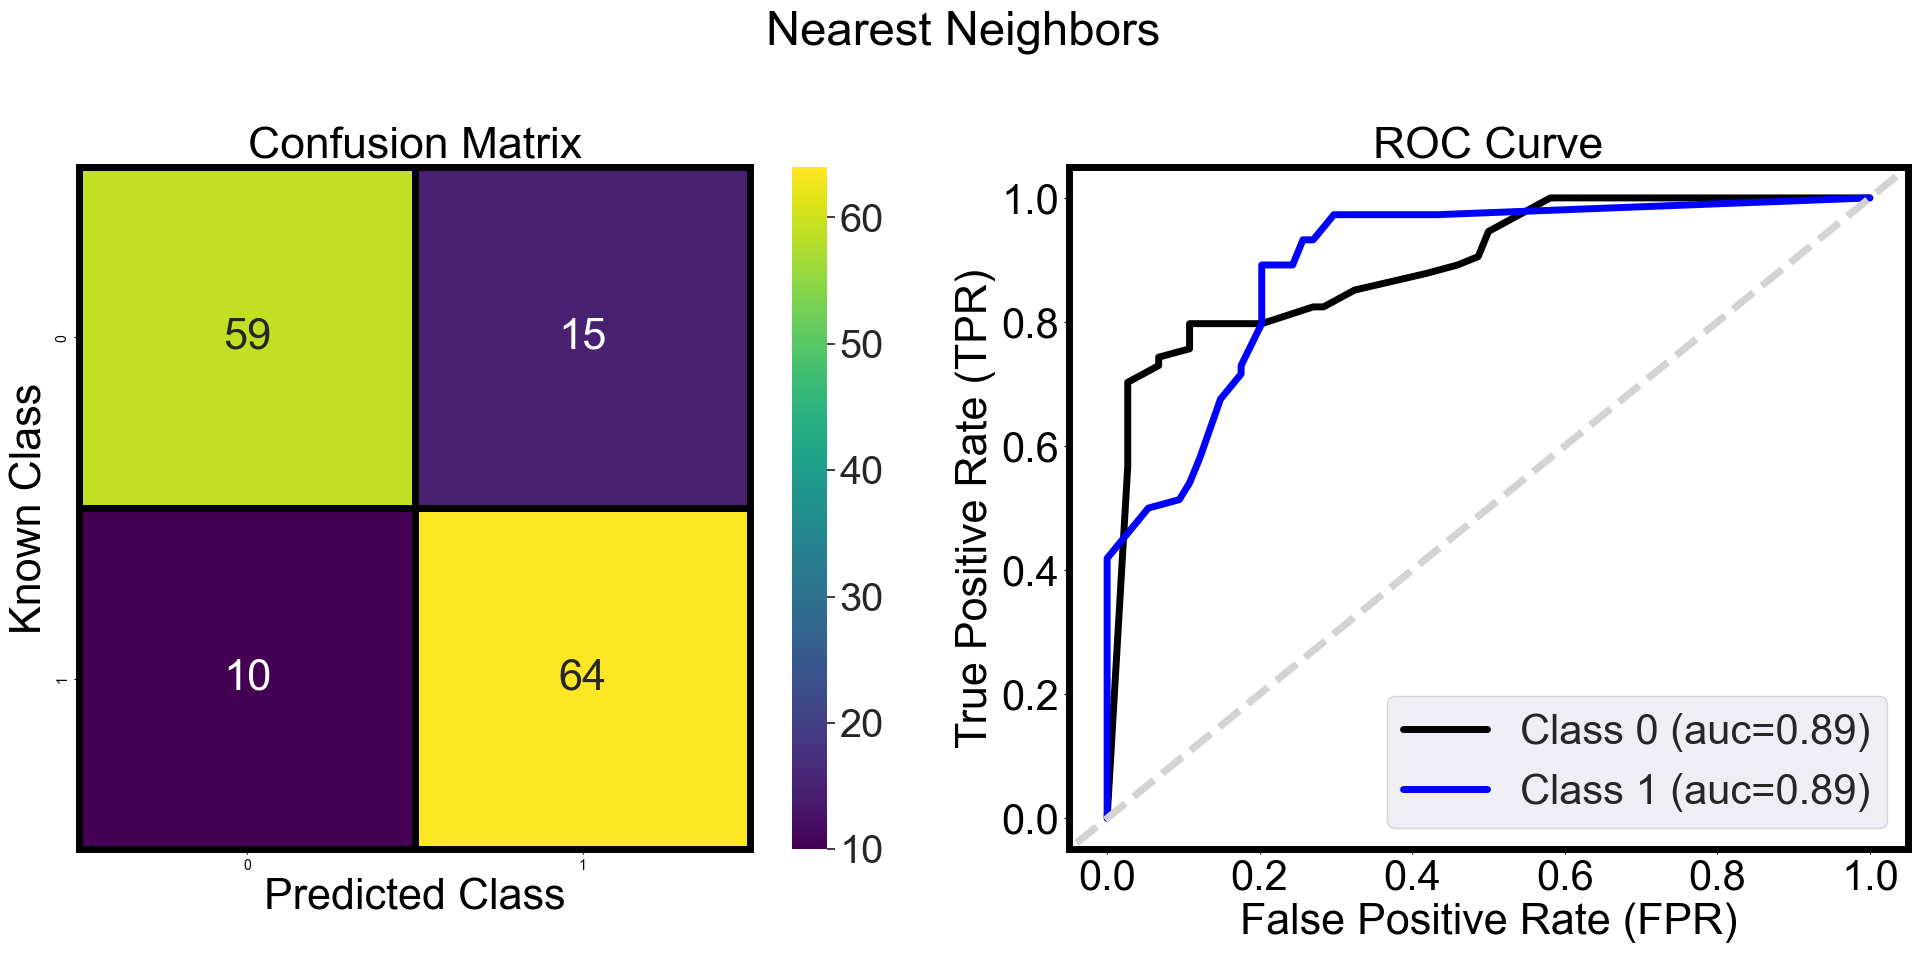

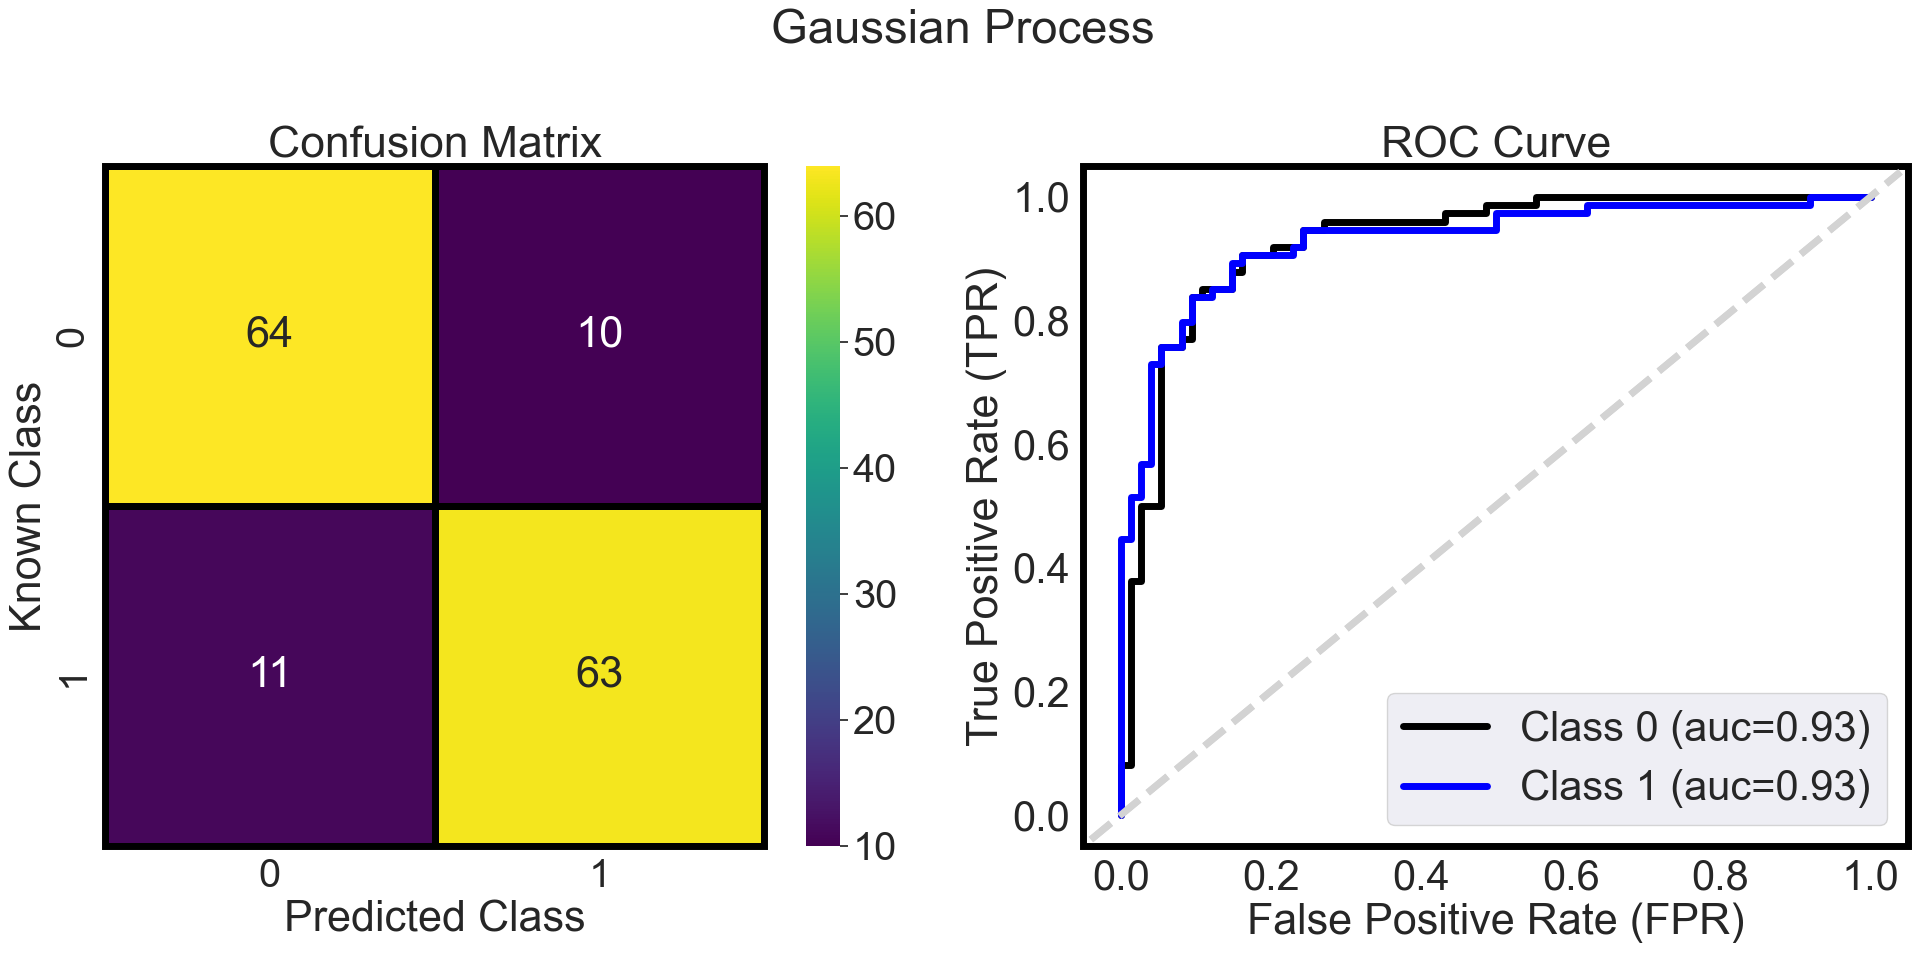

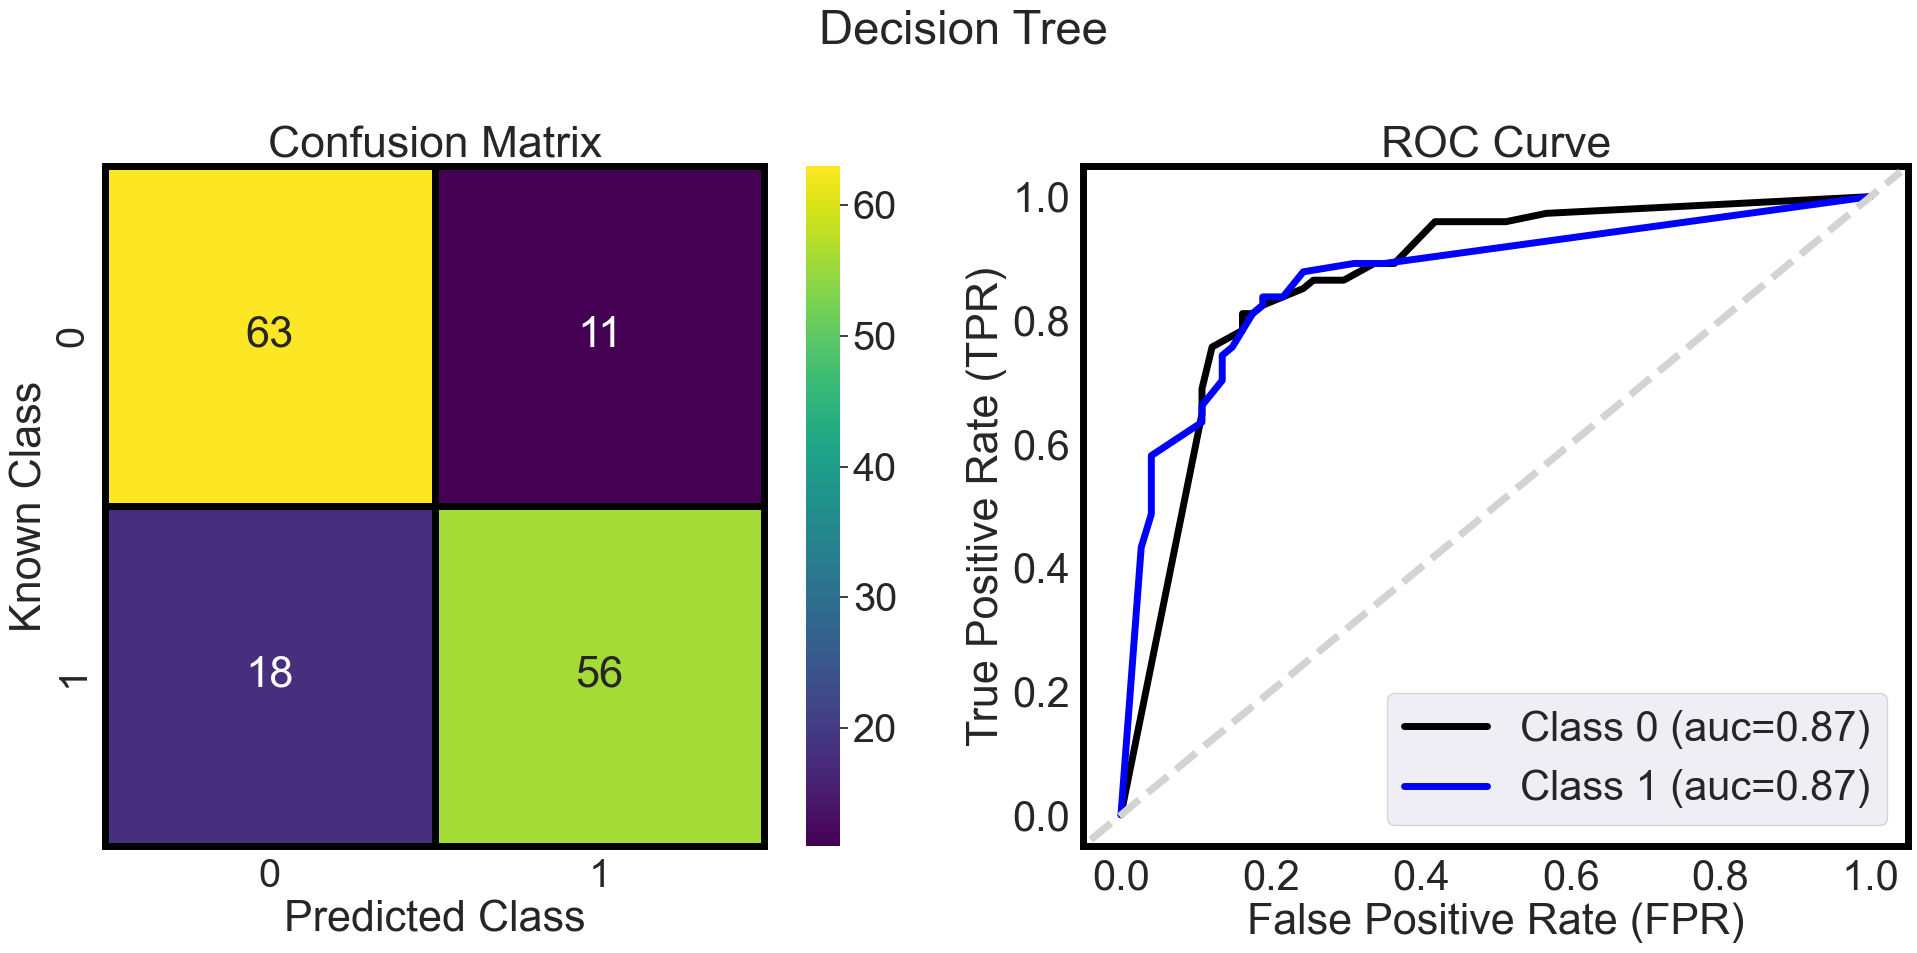

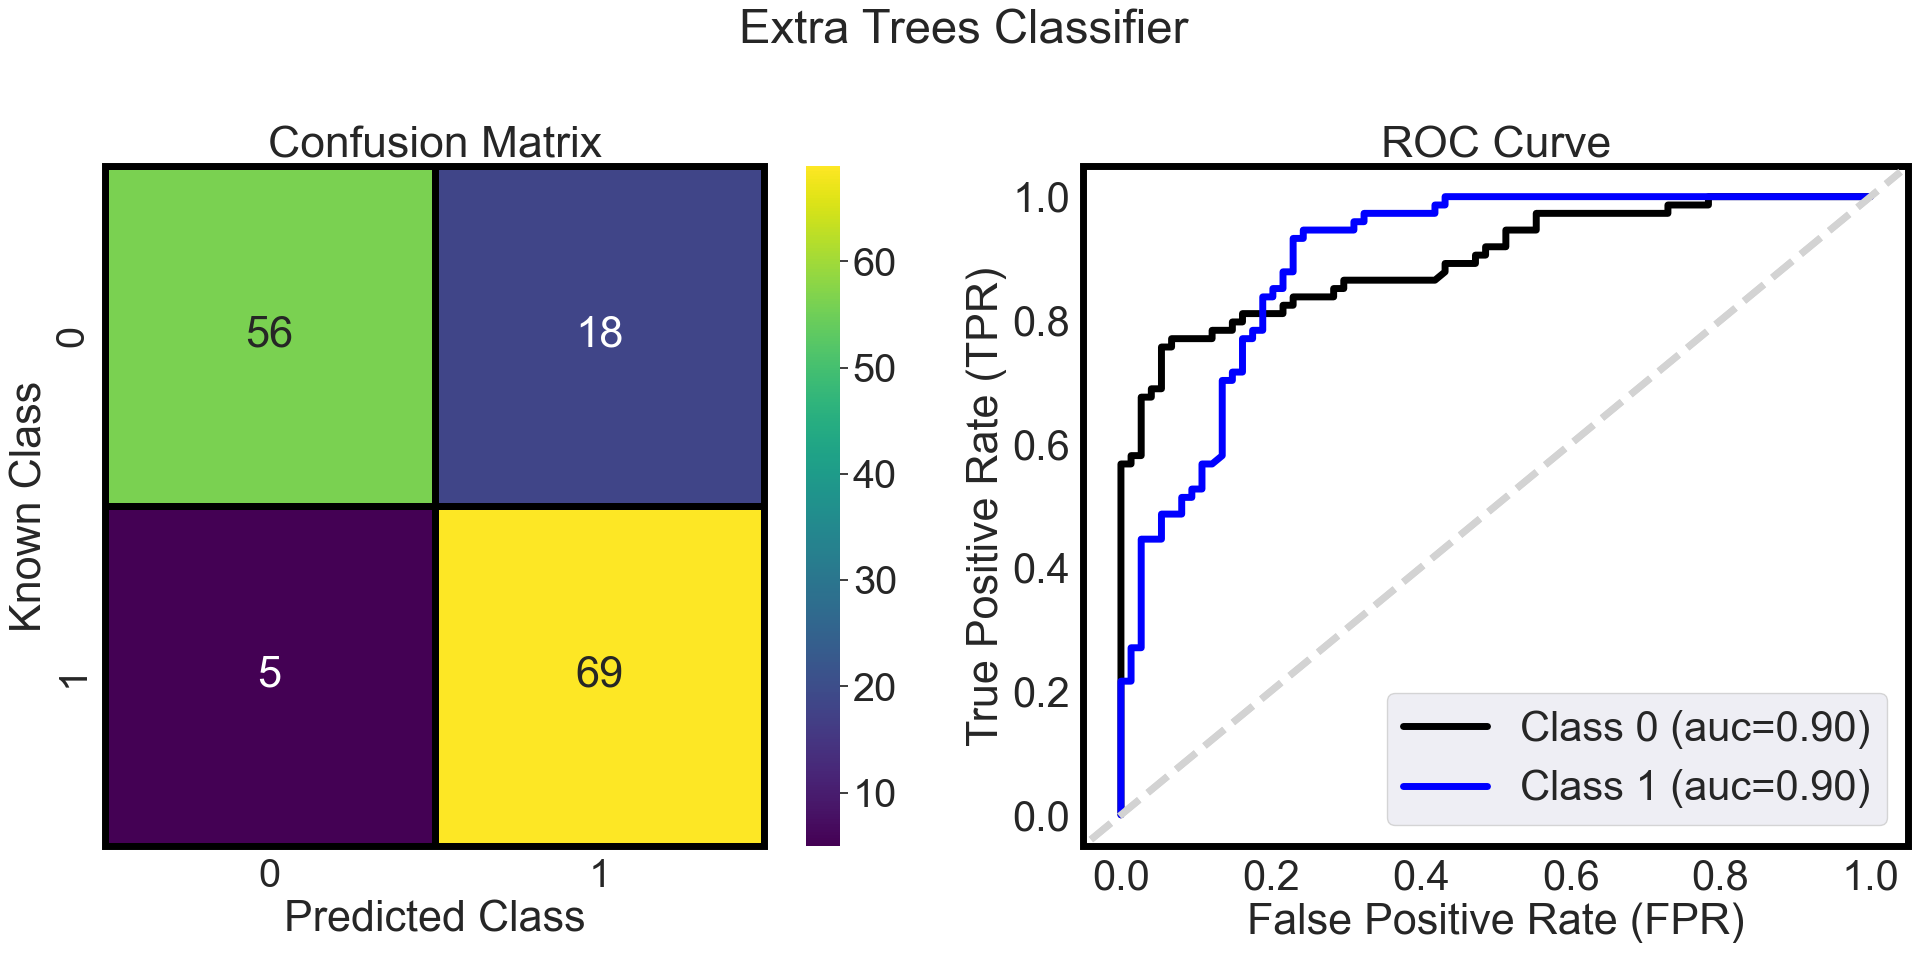

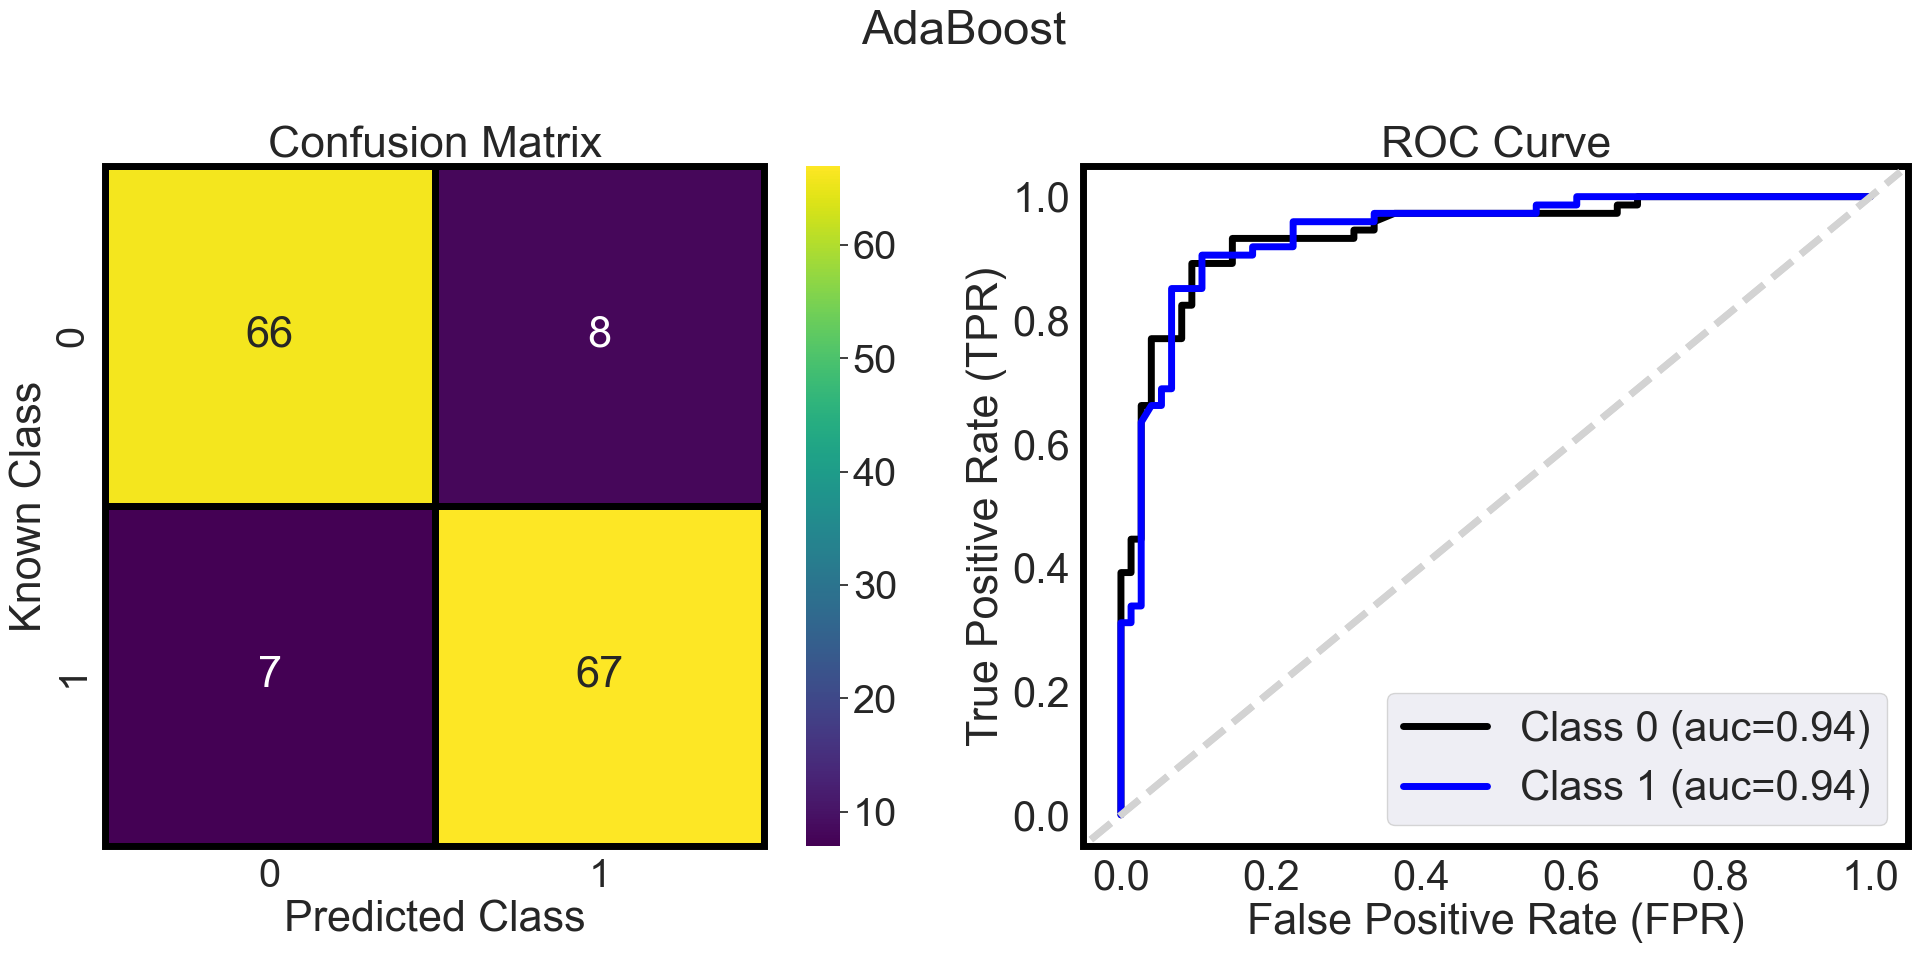

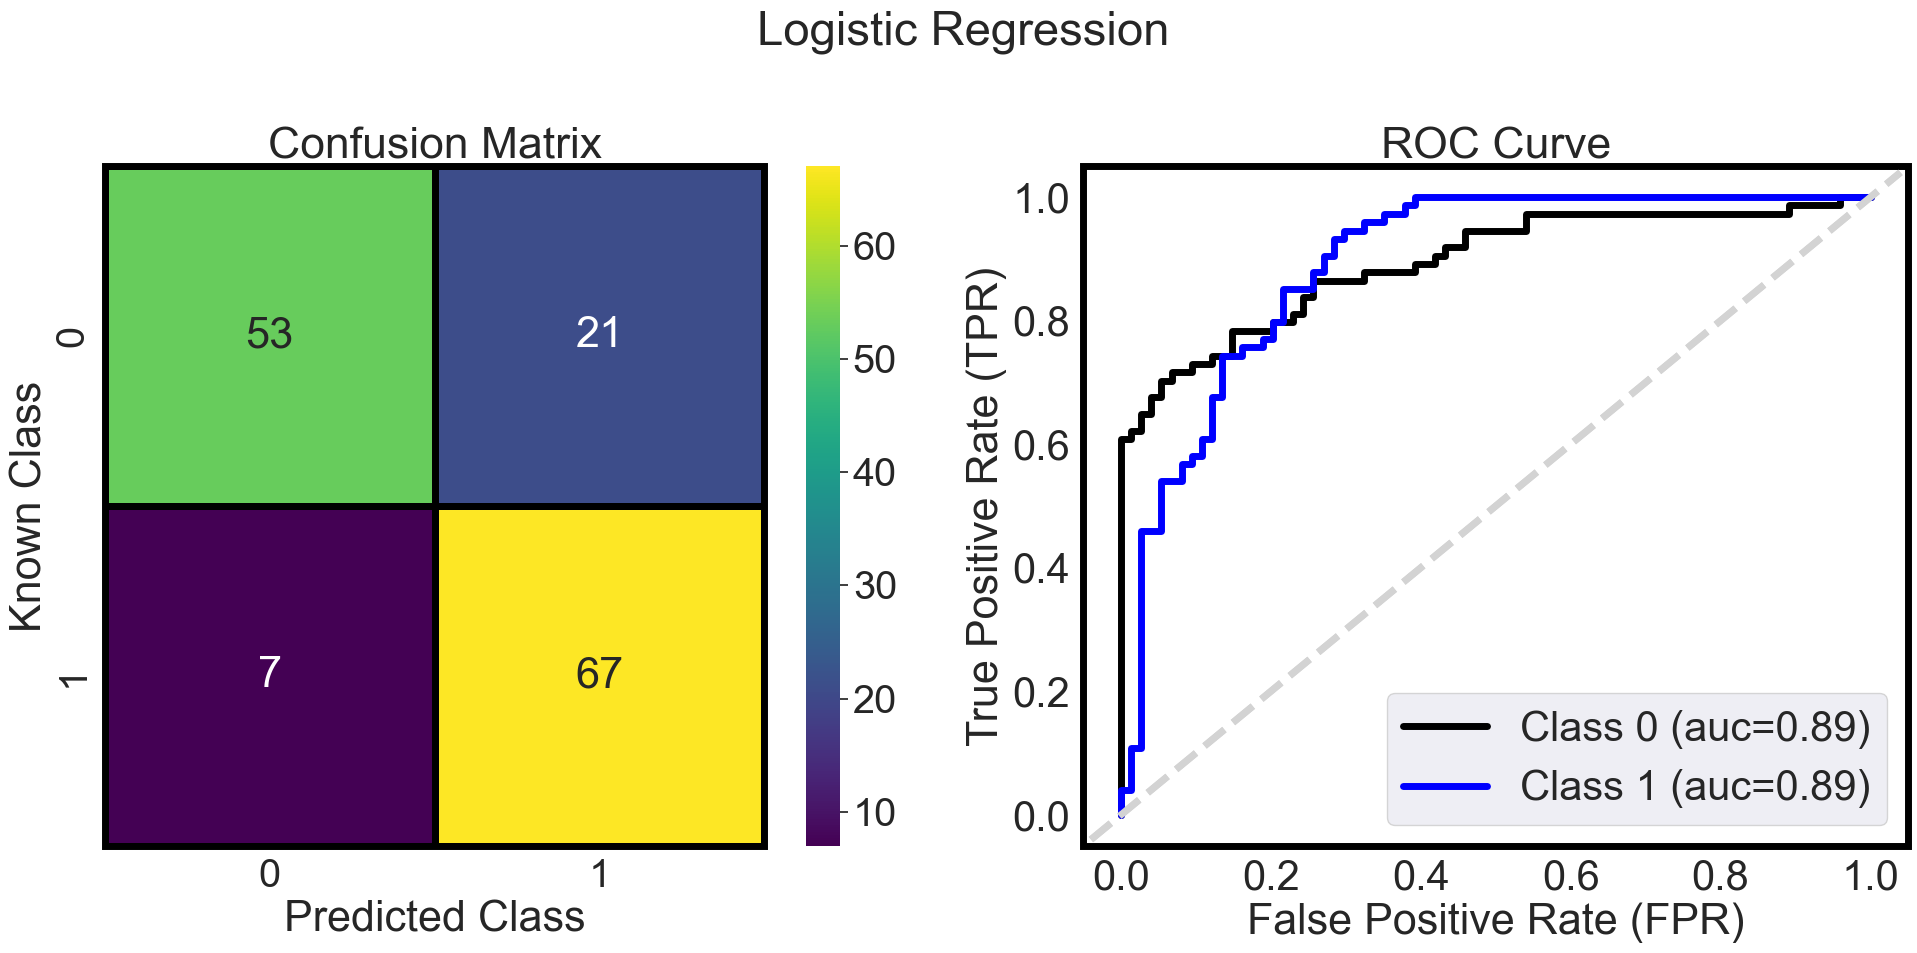

In [45]:
files_plt = []

kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Extra Trees Classifier", "AdaBoost",
         "Logistic Regression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = wf.build_data_from_directory(dirname, max_folds=10)
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.info("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_morderd.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_mordred.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
log.info(df_metrics_for_paper.to_latex())

In [46]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_mordred.png")

Combining 6 images
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
W: 6000 H: 3000
New image will be W:6000 H:18000
Image 0 added at offset height 0
Image 1 added at offset height 3000
Image 2 added at offset height 6000
Image 3 added at offset height 9000
Image 4 added at offset height 12000
Image 5 added at offset height 15000


# Now first we split 90%-10% (train-test)

We need to evaluate the performace of our model on an external test set. If you are not familiar with the process please read the paper section where this is explained.

In [47]:
data = pd.read_csv("../First_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

We know which data points we are using for test set, for consistency reasons. However if you have much more data and you dont know which ones you want to use as a training set, or you don't want to write them manually you could do something like this:

import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.DataFrame(data)

X = df.drop('target', axis=1) y = df['target']

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print("X_test:") print(X_test)

print("y_test:") print(y_test)

In [48]:
test_reactions = [21, 81, 11, 104, 44, 106, 54, 95, 115, 25, 57, 52]

In [49]:
reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64


we romove from the data the test reactions

In [50]:
train_data = data.drop(labels =test_reactions, axis=0,inplace = False)

and we generate the test dataframe

In [51]:
test_data = pd.DataFrame()
test_data = data.iloc[test_reactions]

In [52]:
substratesmiles_train = train_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_train.head()))

catalystsmiles_train = train_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_train.head()))

temp_train = train_data["temperature"]
log.info("DGG: {}".format(temp_train.head()))

ddg_train = train_data["ddg"]
log.info("DGG: {}".format(ddg_train.head()))

Substrate SMILES: 0         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
1    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
2         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
3    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
4         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
1    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
Name: catalyst, dtype: object
DGG: 0   -30.0
1   -30.0
2   -30.0
3   -30.0
4   -30.0
Name: temperature, dtype: float64
DGG: 0    0.569810
1    1.761325
2    1.251493
3    5.229434
4    2.678563
Name: ddg, dtype: float64


In [53]:
target_train = ddg_train

In [54]:
substratesmiles_test = test_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_test.head()))

catalystsmiles_test = test_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_test.head()))

temp_test = train_data["temperature"]
log.info("DGG: {}".format(temp_test.head()))

ddg_test = test_data["ddg"]
log.info("DGG: {}".format(ddg_test.head()))

Substrate SMILES: 21     COC(C=CC=C1)=C1/C=N/C(C2=CC=CC=C2)C3=CC=CC=C3
81                          C=CC/N=C/C1=C(OC)C=CC=C1
11         CC1(CCCCC1)/C=N/C(C2=CC=CC=C2)C3=CC=CC=C3
104      C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
44               C/C(C1=CC=CC=C1)=N\CC2=CC=C(OC)C=C2
Name: substrate, dtype: object
Catalyst SMILES: 21     CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
81     O=C([C@H](C(C)(C)C)NC(N[C@@H]1[C@@H](/N=C/C2=C...
11     CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
104    S=C(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)N[C@H]2[C...
44     O=C([C@@H](C(C)(C)C)NC(N[C@@H]1[C@@H](/N=C/C2=...
Name: catalyst, dtype: object
DGG: 0   -30.0
1   -30.0
2   -30.0
3   -30.0
4   -30.0
Name: temperature, dtype: float64
DGG: 21     5.562698
81     3.446852
11     7.406515
104    0.000000
44     5.464455
Name: ddg, dtype: float64


In [55]:
target_test = ddg_test

Generating Mordred Descriptors for the training set

First for the substrates

In [56]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list_train = [ms.get_mol_from_smiles(s) for s in substratesmiles_train]
subfeatures_df_train = calc.pandas(submolecule_list_train)

100%|█████████████████████████████████████████| 107/107 [00:08<00:00, 12.29it/s]


In [57]:
subfeatures_df_train.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df_train.index)))
threshold = 0.5
subfeatures_df_train.drop(subfeatures_df_train.std()[subfeatures_df_train.std() < threshold].index.values, axis=1)
subfeatures_df_train.columns = [ent.strip() for ent in subfeatures_df_train.columns]
subfeatures_df_train.head()

/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_2122/989884597.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  subfeatures_df_train.drop(subfeatures_df_train.std()[subfeatures_df_train.std() < threshold].index.values, axis=1)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,14.538011,12.482550,0,0,23.734067,2.345955,4.691910,23.734067,1.249161,3.853399,...,9.625162,51.858564,251.1674,6.279185,706,24,94.0,104.0,6.395833,4.180556
1,16.182576,12.923224,0,0,28.376768,2.343528,4.687055,28.376768,1.351275,3.966671,...,9.687009,54.282362,271.1361,7.135161,958,28,104.0,118.0,4.694444,4.805556
2,14.538011,12.482550,0,0,23.734067,2.345955,4.691910,23.734067,1.249161,3.853399,...,9.625162,51.858564,251.1674,6.279185,706,24,94.0,104.0,6.395833,4.180556
3,16.182576,12.923224,0,0,28.376768,2.343528,4.687055,28.376768,1.351275,3.966671,...,9.687009,54.282362,271.1361,7.135161,958,28,104.0,118.0,4.694444,4.805556
4,14.538011,12.482550,0,0,23.734067,2.345955,4.691910,23.734067,1.249161,3.853399,...,9.625162,51.858564,251.1674,6.279185,706,24,94.0,104.0,6.395833,4.180556


In [58]:
log.info(subfeatures_df_train)
subfeatures_types = "some_categorical" 

           ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0    14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
1    16.182576  12.923224      0      0  28.376768  2.343528  4.687055   
2    14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
3    16.182576  12.923224      0      0  28.376768  2.343528  4.687055   
4    14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
..         ...        ...    ...    ...        ...       ...       ...   
102  12.089765  10.061032      0      0  21.313564  2.247466  4.494933   
103   8.554231   7.960160      0      0  15.368571  2.224278  4.448556   
104  16.182576  12.923224      0      0  28.376768  2.343528  4.687055   
105  12.089765  10.061032      0      0  21.313564  2.247466  4.494933   
106   8.554231   7.960160      0      0  15.368571  2.224278  4.448556   

        SpAD_A   SpMAD_A   LogEE_A  ...     SRW10     TSRW10          MW  \
0    23.734067  1.249161  3.853399 

Mordred for catalysts

In [59]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list_train = [ms.get_mol_from_smiles(s) for s in catalystsmiles_train]
catfeatures_df_train = calc.pandas(catmolecule_list_train)

100%|█████████████████████████████████████████| 107/107 [00:25<00:00,  4.18it/s]


# Pearsons Correlation

In [60]:
catfeatures_df_train.dropna(inplace=True, thresh=int(0.9*len(catfeatures_df_train.index)))
threshold = 0.5
catfeatures_df_train.drop(catfeatures_df_train.std()[catfeatures_df_train.std() < threshold].index.values, axis=1)
catfeatures_df_train.columns = [ent.strip() for ent in catfeatures_df_train.columns]
catfeatures_df_train.head()

/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_2122/2726301395.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  catfeatures_df_train.drop(catfeatures_df_train.std()[catfeatures_df_train.std() < threshold].index.values, axis=1)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,21.401108,19.292802,0,0,30.867985,2.425439,4.850878,30.867985,1.102428,4.224506,...,10.282506,63.404103,429.130953,8.757775,2068,43,144.0,162.0,15.215278,5.722222
1,21.401108,19.292802,0,0,30.867985,2.425439,4.850878,30.867985,1.102428,4.224506,...,10.282506,63.404103,429.130953,8.757775,2068,43,144.0,162.0,15.215278,5.722222
2,26.241465,22.162609,0,0,39.436111,2.426470,4.852941,39.436111,1.159886,4.427881,...,10.440303,70.325912,505.162253,8.562072,3643,52,176.0,199.0,15.826389,7.055556
3,26.241465,22.162609,0,0,39.436111,2.426470,4.852941,39.436111,1.159886,4.427881,...,10.440303,70.325912,505.162253,8.562072,3643,52,176.0,199.0,15.826389,7.055556
4,26.977082,23.080194,0,0,40.925850,2.428813,4.857626,40.925850,1.169310,4.457444,...,10.507612,71.558608,519.177903,8.373837,3880,56,182.0,208.0,16.687500,7.277778


In [61]:
log.info(catfeatures_df_train)
catfeatures_types = "some_categorical" 

           ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0    21.401108  19.292802      0      0  30.867985  2.425439  4.850878   
1    21.401108  19.292802      0      0  30.867985  2.425439  4.850878   
2    26.241465  22.162609      0      0  39.436111  2.426470  4.852941   
3    26.241465  22.162609      0      0  39.436111  2.426470  4.852941   
4    26.977082  23.080194      0      0  40.925850  2.428813  4.857626   
..         ...        ...    ...    ...        ...       ...       ...   
102  21.401108  19.292802      0      0  30.867985  2.425439  4.850878   
103  21.401108  19.292802      0      0  30.867985  2.425439  4.850878   
104  16.714811  14.859531      0      0  24.619317  2.420606  4.841212   
105  16.714811  14.859531      0      0  24.619317  2.420606  4.841212   
106  16.714811  14.859531      0      0  24.619317  2.420606  4.841212   

        SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  \
0    30.867985  1.102428  4.224506

# Pearson correlation coefficent 

In [62]:
subreasonable_predicted_properties, subsignificant_features = wf.find_correlating_features(subfeatures_df_train, target_train, thresh=0.36, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0      0.569810
1      1.761325
2      1.251493
3      5.229434
4      2.678563
         ...   
113    0.000000
114    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: ddg, Length: 107, dtype: float64
Significance will be calculated for the correlations
GATS3c: -0.4470 P: 0.0002 Significant at 0.0500 level? True
GATS3se: -0.4752 P: 0.0002 Significant at 0.0500 level? True
GATS3pe: -0.4085 P: 0.0002 Significant at 0.0500 level? True
GATS3are: -0.4365 P: 0.0002 Significant at 0.0500 level? True
Lipinski: -0.3801 P: 0.0002 Significant at 0.0500 level? True
GGI9: 0.3833 P: 0.0002 Significant at 0.0500 level? True


In [63]:
log.info("{} {}".format(subreasonable_predicted_properties, len(subreasonable_predicted_properties)))
log.info("{} {}".format(subsignificant_features, len(subsignificant_features)))
use_significant = True
use_reasonable = False

['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9'] 6
['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9'] 6


In [64]:
catreasonable_predicted_properties, catsignificant_features = wf.find_correlating_features(catfeatures_df_train, target_train, thresh=0.55, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0      0.569810
1      1.761325
2      1.251493
3      5.229434
4      2.678563
         ...   
113    0.000000
114    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: ddg, Length: 107, dtype: float64
Significance will be calculated for the correlations
VE3_A: 0.5949 P: 0.0002 Significant at 0.0500 level? True
ATS5Z: 0.6073 P: 0.0002 Significant at 0.0500 level? True
ATS5m: 0.5637 P: 0.0002 Significant at 0.0500 level? True
ATS5v: 0.6028 P: 0.0002 Significant at 0.0500 level? True
ATS6v: 0.6053 P: 0.0002 Significant at 0.0500 level? True
ATS6se: 0.6276 P: 0.0002 Significant at 0.0500 level? True
ATS7se: 0.5807 P: 0.0002 Significant at 0.0500 level? True
ATS6pe: 0.6284 P: 0.0002 Significant at 0.0500 level? True
ATS7pe: 0.5761 P: 0.0002 Significant at 0.0500 level? True
ATS6are: 0.6272 P: 0.0002 Significant at 0.0500 level? True
ATS7are: 0.5759 P: 0.0002 Significant at 0.0500 level? True
ATS5p: 0.5862 P: 0.0002 Significant at 0.0500 level? True
ATS6p: 0.6165 P: 0.0002 Sign

In [65]:
log.info("{} {}".format(catreasonable_predicted_properties, len(catreasonable_predicted_properties)))
log.info("{} {}".format(catsignificant_features, len(catsignificant_features)))
use_significant = True
use_reasonable = False

['VE3_A', 'ATS5Z', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe', 'ATS7pe', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c', 'AATSC6c', 'MATS1are', 'Xpc-6dv', 'MAXaaCH', 'MAXaasC', 'PEOE_VSA6', 'MDEC-22', 'GGI3', 'GGI6', 'GGI8'] 31
['VE3_A', 'ATS5Z', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe', 'ATS7pe', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i', 'ATS7i', 'AATS8i', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c', 'AATSC6c', 'MATS1are', 'Xpc-6dv', 'MAXaaCH', 'MAXaasC', 'PEOE_VSA6', 'MDEC-22', 'GGI3', 'GGI6', 'GGI8'] 31


In [66]:
subfeats_df_train = pd.DataFrame()

if use_significant is True:
    for k in subsignificant_features:
        subfeats_df_train[k] = subfeatures_df_train[k]
        
elif use_reasonable is True:
    for k in subreasonable_predicted_properties:
        subfeats_df_train[k] = subfeatures_df_train[k]

In [67]:
catfeats_df_train = pd.DataFrame()

if use_significant is True:
    for k in catsignificant_features:
        catfeats_df_train[k] = catfeatures_df_train[k]
        
elif use_reasonable is True:
    for k in catreasonable_predicted_properties:
        catfeats_df_train[k] = catfeatures_df_train[k]

In [68]:
features_df_train = subfeats_df_train.join(catfeats_df_train, lsuffix="subfeats_df_train", rsuffix="catfeats_df_train")

In [69]:
features_df_train = features_df_train.join(temp_train.reset_index(drop=True))

In [70]:
features_df_train.to_csv('features_train.csv')

# Classify the training set

In [71]:
classes_train=[]
for index, value in ddg_train.items():
    if value < 4:
        classes_train.append(0)
    else:
        classes_train.append(1)

In [72]:
classes_train
class_targets_df_train = pd.DataFrame(np.array([classes_train]).T, columns=["classes"])
features_and_classes_df_train = features_df_train.copy()
features_and_classes_df_train["classes"] = classes_train

In [73]:
class_targets_df_train["classes"].values

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [74]:
features_df_train.to_csv("features_train.csv")

# Data Scalling

In [75]:
features_df_train, categorical_indxs = wf.feature_categorization(features_df_train, feature_types = "some_categorical")

-----
Categorical features not provided. Trying to guess the categorical features automatically.
-----
Automatically assigned categorical indices:
[] 0
Automatically assigned categorical features:
[] 0
**Please check if the automatic assignment is correct. If not, please provide the indices of the categorical features.**
-----
Index(['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9', 'VE3_A',
       'ATS5Z', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe',
       'ATS7pe', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i',
       'ATS7i', 'AATS8i', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c',
       'AATSC6c', 'MATS1are', 'Xpc-6dv', 'MAXaaCH', 'MAXaasC', 'PEOE_VSA6',
       'MDEC-22', 'GGI3', 'GGI6', 'GGI8', 'temperature'],
      dtype='object')


# Synthetic Sampling for the training

In [76]:
nneighbours = min(5, len(class_targets_df_train[class_targets_df_train["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

feature_types = "no_categorical"
# feature_types is set when the fingerprints are calculated
# No categorical
if feature_types == "no_categorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some categorical - Need to provide the indexes
elif feature_types == "some_categorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=categorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All categorical
elif feature_types == "categorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


In [77]:
log.info("Feature decriptions:\n{}".format(features_df_train.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df_train.columns.values))

Feature decriptions:
['GATS3c' 'GATS3se' 'GATS3pe' 'GATS3are' 'Lipinski' 'GGI9' 'VE3_A' 'ATS5Z'
 'ATS5m' 'ATS5v' 'ATS6v' 'ATS6se' 'ATS7se' 'ATS6pe' 'ATS7pe' 'ATS6are'
 'ATS7are' 'ATS5p' 'ATS6p' 'ATS7p' 'ATS6i' 'ATS7i' 'AATS8i' 'ATSC3se'
 'ATSC3pe' 'ATSC3are' 'AATSC0c' 'AATSC6c' 'MATS1are' 'Xpc-6dv' 'MAXaaCH'
 'MAXaasC' 'PEOE_VSA6' 'MDEC-22' 'GGI3' 'GGI6' 'GGI8' 'temperature']
Classes/Targets descriptions:
['classes']


In [78]:
features_smote_train, classes_smote_train = sm.fit_resample(features_df_train.to_numpy(), class_targets_df_train.to_numpy())
n_sythetic_points = features_smote_train.shape[0] - len(features_df_train.index)
log.info("SMOTE has added {} sythetic features to balance the classes".format(n_sythetic_points))

/Users/matina/anaconda3/envs/pythiachem/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
SMOTE has added 29 sythetic features to balance the classes


In [79]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote_train, features_smote_train.shape, classes_smote_train, classes_smote_train.shape))

Resampled X
[[0.46325819 0.55372616 0.67395789 ... 0.17452007 0.42378185 1.        ]
 [0.29986582 0.42847354 0.47795704 ... 0.17452007 0.42378185 1.        ]
 [0.46325819 0.55372616 0.67395789 ... 0.52356021 0.64282521 1.        ]
 ...
 [0.46325819 0.55372616 0.67395789 ... 0.30541012 0.5113992  1.        ]
 [0.50520789 0.5940114  0.69267249 ... 0.04450262 0.19043362 0.80667162]
 [0.44032897 0.65778335 0.61743684 ... 0.89445109 0.98755724 0.05362422]]
(136, 38)
Resampled y:
[0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(136,)


In [80]:
features_smote_df_train = pd.DataFrame(data=features_smote_train, columns=features_df_train.columns.values)
classes_smote_df_train = pd.DataFrame(data=classes_smote_train, columns=["classes"])

comb_df_res = features_smote_df_train.copy()
comb_df_res["classes"] = classes_smote_train
comb_df_res.to_csv("resampled_synthetic_data_set_train.csv")
comb_df_res

,GATS3c,GATS3se,GATS3pe,GATS3are,Lipinski,GGI9,VE3_A,ATS5Z,ATS5m,ATS5v,...,Xpc-6dv,MAXaaCH,MAXaasC,PEOE_VSA6,MDEC-22,GGI3,GGI6,GGI8,temperature,classes
0,0.463258,0.553726,0.673958,0.609793,1.0,0.000000,0.382712,0.410577,0.395021,0.334544,...,0.516883,0.153933,0.184482,0.206274,0.000000,0.526316,0.174520,0.423782,1.000000,0
1,0.299866,0.428474,0.477957,0.447722,1.0,0.157895,0.382712,0.410577,0.395021,0.334544,...,0.516883,0.153933,0.184482,0.206274,0.000000,0.526316,0.174520,0.423782,1.000000,0
2,0.463258,0.553726,0.673958,0.609793,1.0,0.000000,0.632332,0.621316,0.609724,0.525455,...,0.583422,0.874918,0.895225,0.507491,0.346513,0.657895,0.523560,0.642825,1.000000,0
3,0.299866,0.428474,0.477957,0.447722,1.0,0.157895,0.632332,0.621316,0.609724,0.525455,...,0.583422,0.874918,0.895225,0.507491,0.346513,0.657895,0.523560,0.642825,1.000000,1
4,0.463258,0.553726,0.673958,0.609793,1.0,0.000000,0.733978,0.703270,0.680002,0.616881,...,0.705704,0.884945,0.897609,0.507491,0.241952,0.815789,0.610820,0.730443,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.463258,0.553726,0.673958,0.609793,1.0,0.000000,0.382712,0.410577,0.395021,0.334544,...,0.516883,0.153933,0.184482,0.206274,0.000000,0.526316,0.174520,0.423782,1.000000,0
132,0.299866,0.428474,0.477957,0.447722,1.0,0.157895,0.609282,0.453220,0.497890,0.261535,...,0.277125,0.041799,0.050094,0.056012,0.078862,0.583826,0.316271,0.534174,1.000000,0
133,0.463258,0.553726,0.673958,0.609793,1.0,0.000000,0.492849,0.508276,0.483100,0.430640,...,0.563669,0.158389,0.185607,0.206274,0.000000,0.631579,0.305410,0.511399,1.000000,0
134,0.505208,0.594011,0.692672,0.639362,1.0,0.016280,0.419819,0.263222,0.258773,0.213093,...,0.340437,0.858672,0.894448,0.240974,0.276380,0.479532,0.044503,0.190434,0.806672,0


# Handling the Test Set

First we generate Mordred descriptors for the substrates and catalysts of the test set and then we use 
the descriptors that the training set is using

In [81]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list_test = [ms.get_mol_from_smiles(s) for s in substratesmiles_test]
subfeatures_df_test = calc.pandas(submolecule_list_test)

100%|███████████████████████████████████████████| 12/12 [00:01<00:00,  6.08it/s]


In [82]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list_test = [ms.get_mol_from_smiles(s) for s in catalystsmiles_test]
catfeatures_df_test = calc.pandas(catmolecule_list_test)

100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.67it/s]


In [83]:
testfeats_df_sub = pd.DataFrame()
testcontinous_features = []
testcatagorical_features = []

# Make sure feature cover all of the molecule if not don't use them as we will loose data points doing this
n_features = len(ddg_train)

# Add Mordred descriptors
for ent in subreasonable_predicted_properties:
    testfeats_df_sub[ent] = subfeatures_df_test[ent].values 
    testcontinous_features.append(ent)
print(testfeats_df_sub)

      GATS3c   GATS3se   GATS3pe  GATS3are  Lipinski      GGI9
0   0.958146  0.950708  0.917143  0.928732      True  0.096250
1   1.019501  1.067694  0.981975  1.009922      True  0.000000
2   0.953450  1.030349  1.019503  1.015825     False  0.045000
3   0.981164  1.031415  0.978073  0.989808      True  0.045000
4   1.079664  1.193379  1.181657  1.201571      True  0.062500
5   1.306779  1.612830  1.359694  1.462054      True  0.000000
6   1.101164  1.187627  1.169919  1.166806      True  0.000000
7   0.983640  1.056407  1.070055  1.058030      True  0.000000
8   1.101164  1.187627  1.169919  1.166806      True  0.000000
9   0.751475  0.692028  0.804199  0.770557      True  0.013117
10  1.101164  1.187627  1.169919  1.166806      True  0.000000
11  1.101164  1.187627  1.169919  1.166806      True  0.000000


In [84]:
testfeats_df_cat = pd.DataFrame()
testcontinous_features = []
testcatagorical_features = []

# Make sure feature cover all of the molecule if not don't use them as we will loose data points doing this
n_features = len(ddg_train)

# Add Mordred descriptors
for ent in catreasonable_predicted_properties:
#     tmp = testfeatures_df[ent].copy()
#     tmp.dropna(inplace=True)
#     if len(tmp.values) == n_features:
    testfeats_df_cat[ent] = catfeatures_df_test[ent].values 
#     print(testfeats_df[ent])
    testcontinous_features.append(ent)
#     else:
#         log.warning("Dropping feature because it is not avaliable for all molecules")
#     del tmp
print(testfeats_df_cat)

       VE3_A   ATS5Z         ATS5m         ATS5v         ATS6v       ATS6se  \
0   3.116852  4469.0  16828.947682  39537.363935  41046.436724  1830.262018   
1   3.011422  4315.0  15392.622928  43113.080733  44658.369232  1961.626346   
2   3.116852  4469.0  16828.947682  39537.363935  41046.436724  1830.262018   
3   2.549356  2644.0  10244.498446  18604.384302  16248.738971   805.900338   
4   3.011422  3875.0  13672.618316  41504.320794  43299.754273  1992.660968   
5   2.549356  2644.0  10244.498446  18604.384302  16248.738971   805.900338   
6   3.116852  4093.0  15350.098985  38134.387977  39558.730343  1856.091444   
7   3.011422  4315.0  15392.622928  43113.080733  44658.369232  1961.626346   
8   2.138716  1992.0   7945.773694  11967.479765  10656.801016   567.809490   
9   3.116852  4469.0  16828.947682  39537.363935  41046.436724  1830.262018   
10  2.856647  3734.0  13986.347236  31180.594742  30949.042524  1493.323210   
11  3.116852  4469.0  16828.947682  39537.363935  41

In [85]:
features_df_test = testfeats_df_sub.join(testfeats_df_cat, lsuffix="subfeats_df", rsuffix="catfeats_df")

In [86]:
features_df_test = features_df_test.join(temp_test.reset_index(drop=True))

In [87]:
features_df_train, categorical_indxs = wf.feature_categorization(features_df_test, feature_types = "some_categorical")

-----
Categorical features not provided. Trying to guess the categorical features automatically.
-----
Automatically assigned categorical indices:
[] 0
Automatically assigned categorical features:
[] 0
**Please check if the automatic assignment is correct. If not, please provide the indices of the categorical features.**
-----
Index(['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9', 'VE3_A',
       'ATS5Z', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe',
       'ATS7pe', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i',
       'ATS7i', 'AATS8i', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c',
       'AATSC6c', 'MATS1are', 'Xpc-6dv', 'MAXaaCH', 'MAXaasC', 'PEOE_VSA6',
       'MDEC-22', 'GGI3', 'GGI6', 'GGI8', 'temperature'],
      dtype='object')


In [88]:
classes_test=[]
for index, value in ddg_test.items():
    if value < 4:
        classes_test.append(0)
    else:
        classes_test.append(1)

# Define Xtrain, Xtest, Ytrain, Ytest

In [89]:
Xtrain = features_smote_df_train
Xtest = features_df_test
Ytrain = classes_smote_df_train
Ytest = classes_test

# Time for ML

In [90]:
kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier", "AdaBoost",
         "LogisticRegression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "NearestNeighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "GaussianProcess": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "DecisionTree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "LogisticRegression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

In [91]:
%%capture
wf.test_classifiers_with_optimization(Xtrain,Xtest, Ytrain , Ytest, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, scale = False, cv=5, n_repeats=10,no_train_output=False,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

Features: Index(['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'GGI9', 'VE3_A',
       'ATS5Z', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe',
       'ATS7pe', 'ATS6are', 'ATS7are', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS6i',
       'ATS7i', 'AATS8i', 'ATSC3se', 'ATSC3pe', 'ATSC3are', 'AATSC0c',
       'AATSC6c', 'MATS1are', 'Xpc-6dv', 'MAXaaCH', 'MAXaasC', 'PEOE_VSA6',
       'MDEC-22', 'GGI3', 'GGI6', 'GGI8', 'temperature'],
      dtype='object')
Using unscaled features
data:
     index    GATS3c   GATS3se   GATS3pe  GATS3are  Lipinski      GGI9  \
0        0  0.463258  0.553726  0.673958  0.609793       1.0  0.000000   
1        1  0.299866  0.428474  0.477957  0.447722       1.0  0.157895   
2        2  0.463258  0.553726  0.673958  0.609793       1.0  0.000000   
3        3  0.299866  0.428474  0.477957  0.447722       1.0  0.157895   
4        4  0.463258  0.553726  0.673958  0.609793       1.0  0.000000   
..     ...       ...       ...       ...       ...       ... 

	 -----Index | Predicted | Label
	------------------
	  0   |   1   |   1
	  1   |   1   |   0
	  2   |   1   |   1
	  3   |   1   |   0
	  4   |   1   |   1
	  5   |   0   |   0
	  6   |   1   |   1
	  7   |   1   |   0
	  8   |   0   |   0
	  9   |   1   |   1
	  10   |   1   |   0
	  11   |   1   |   1
-----

[[1.         0.6       ]
 [0.33333333 1.        ]
 [0.5        0.75      ]
 [6.         6.        ]] [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]] 0.8333333333333333 0.0

-----
Begin LogisticRegression
-----

Directory LogisticRegression already exists will be overwritten

	----- Predicting using: LogisticRegression -----
	ROC analysis area under the curve: 0.7777777777777779
	Confusion matrix (LogisticRegression):
[[4 2]
 [0 6]]


	score (LogisticRegression): 0.8333333333333334
	Imbalance reports:
	Imbalance classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.67      1.00      0.80      0.82      0.64 

In [92]:
directory_names = wf.directory_names(kfold_clf_names)


NearestNeighbors
-------------

Reading 0.csv
Saving plot to ddg_nearestneighbors_morderd.png
['ddg_nearestneighbors_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 2, 'fn': 0, 'tp': 6}
[[4 2]
 [0 6]]
(0, 1)
2
Support cannot be gotten from classification report

GaussianProcess
-------------

Reading 0.csv
Saving plot to ddg_gaussianprocess_morderd.png
['ddg_nearestneighbors_morderd.png', 'ddg_gaussianprocess_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 2, 'fn': 1, 'tp': 5}
[[4 2]
 [1 5]]
(0, 1)
2
Support cannot be gotten from classification report
/var/folders/dc/587y55y97v7fzbkqycm2n61h0000gn/T/ipykernel_2122/3763766045.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))

DecisionTree
-------------

Reading 0.csv
Savin

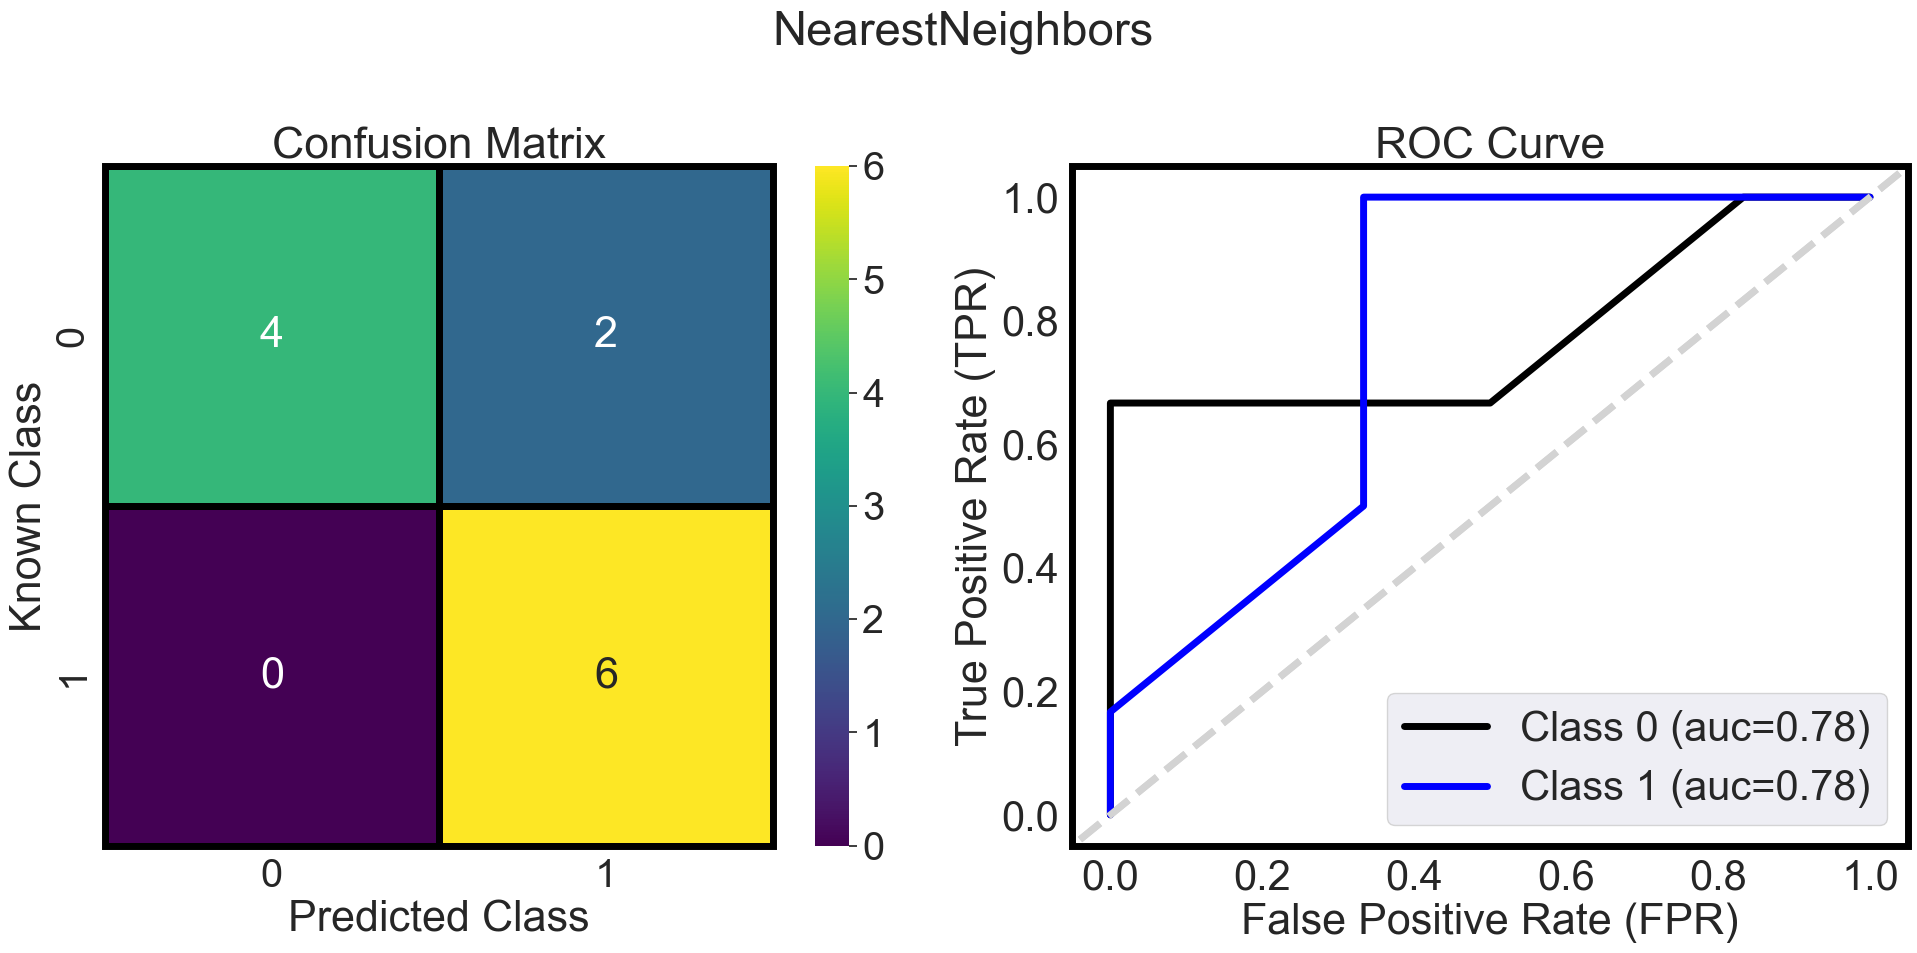

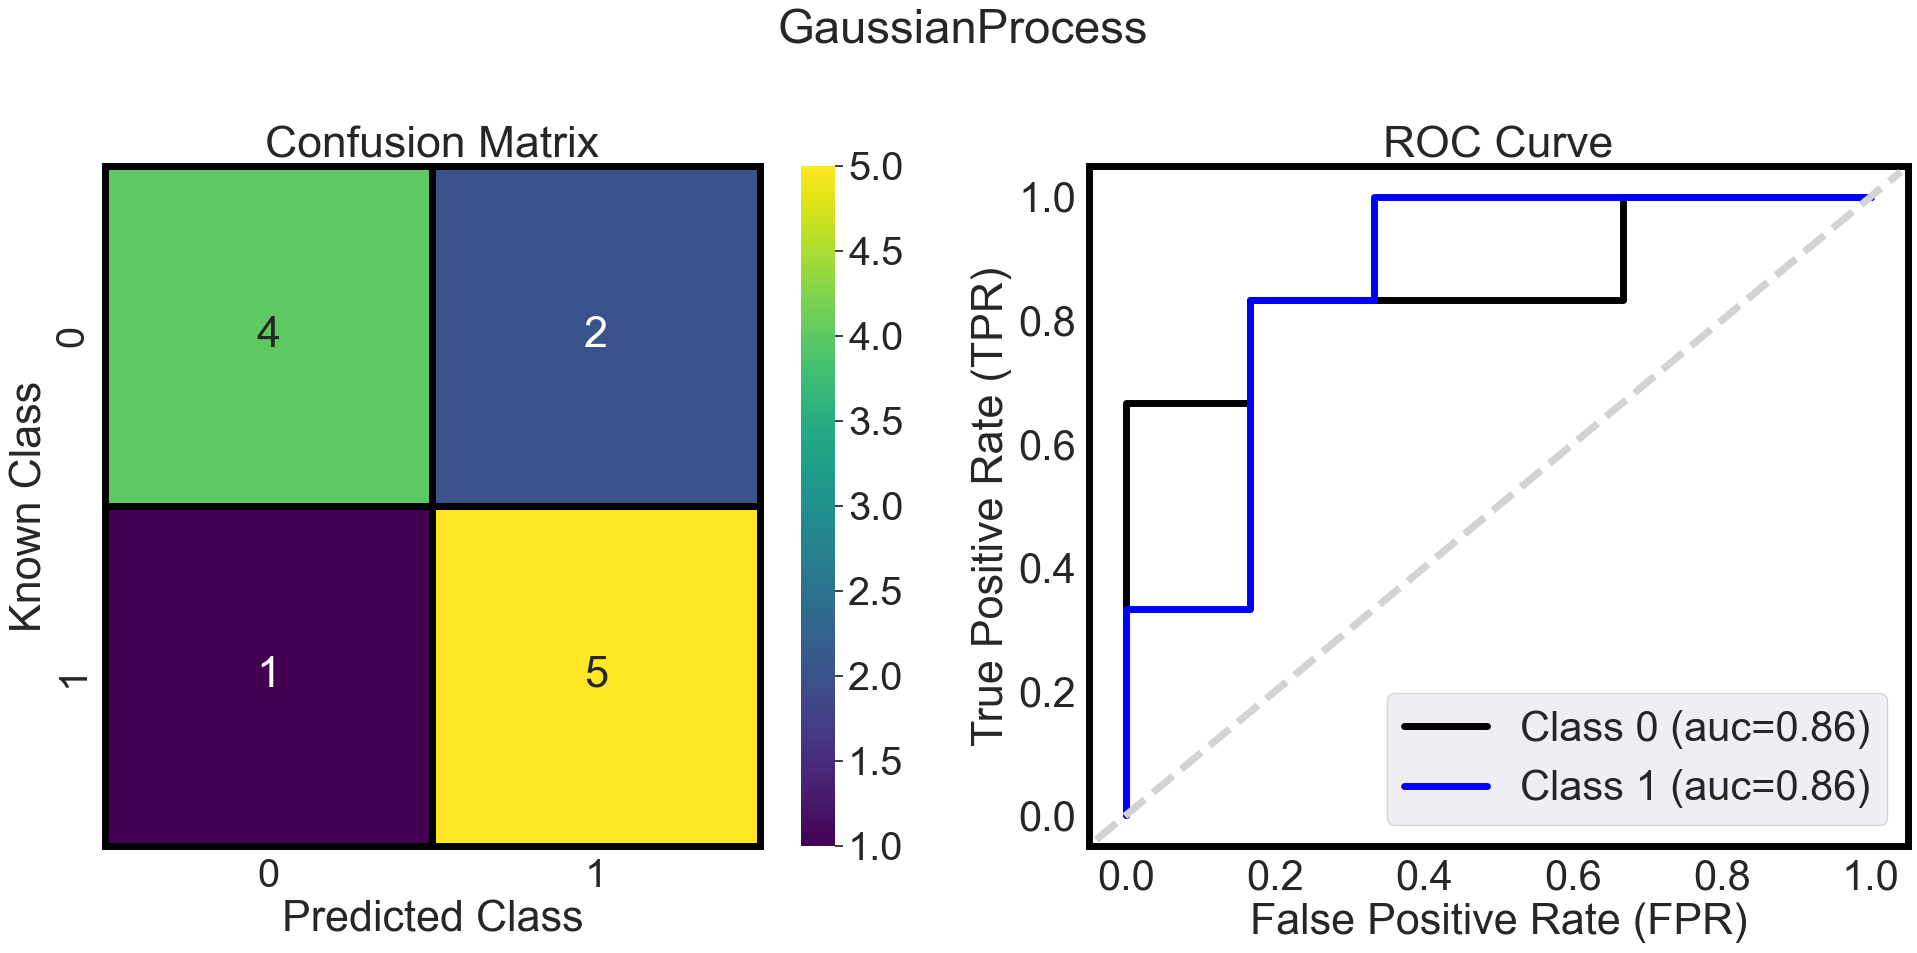

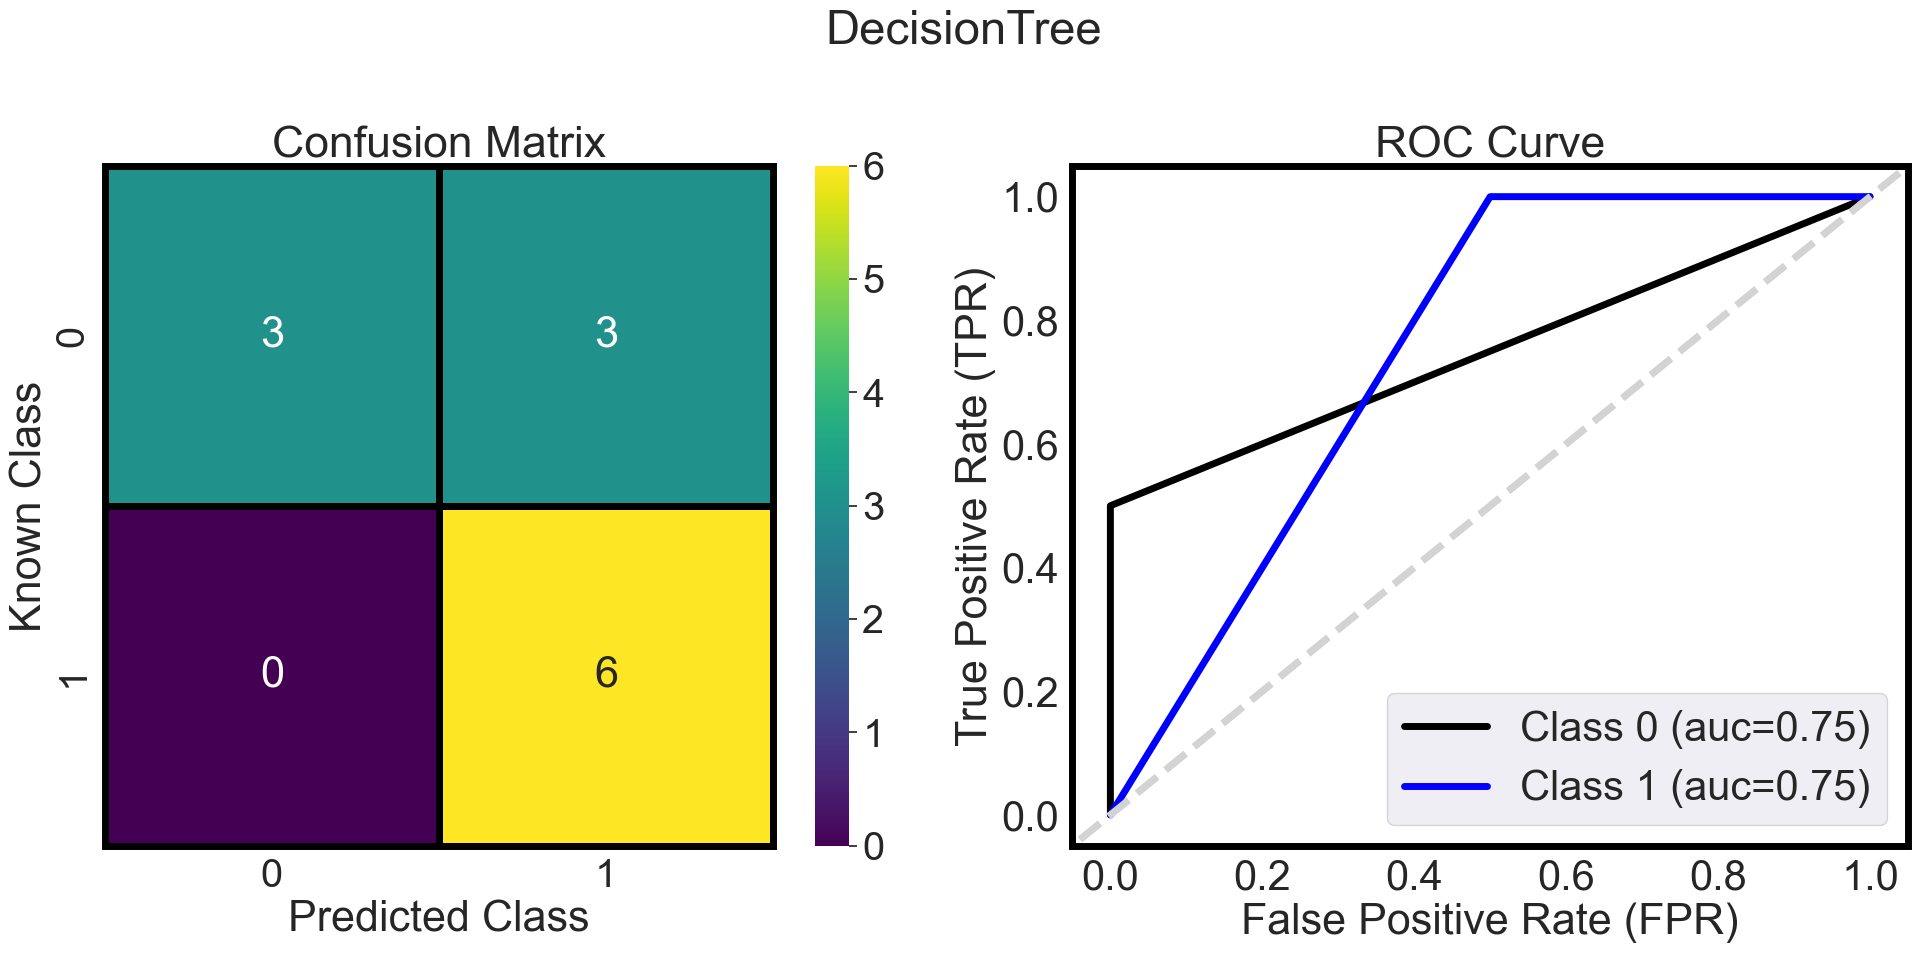

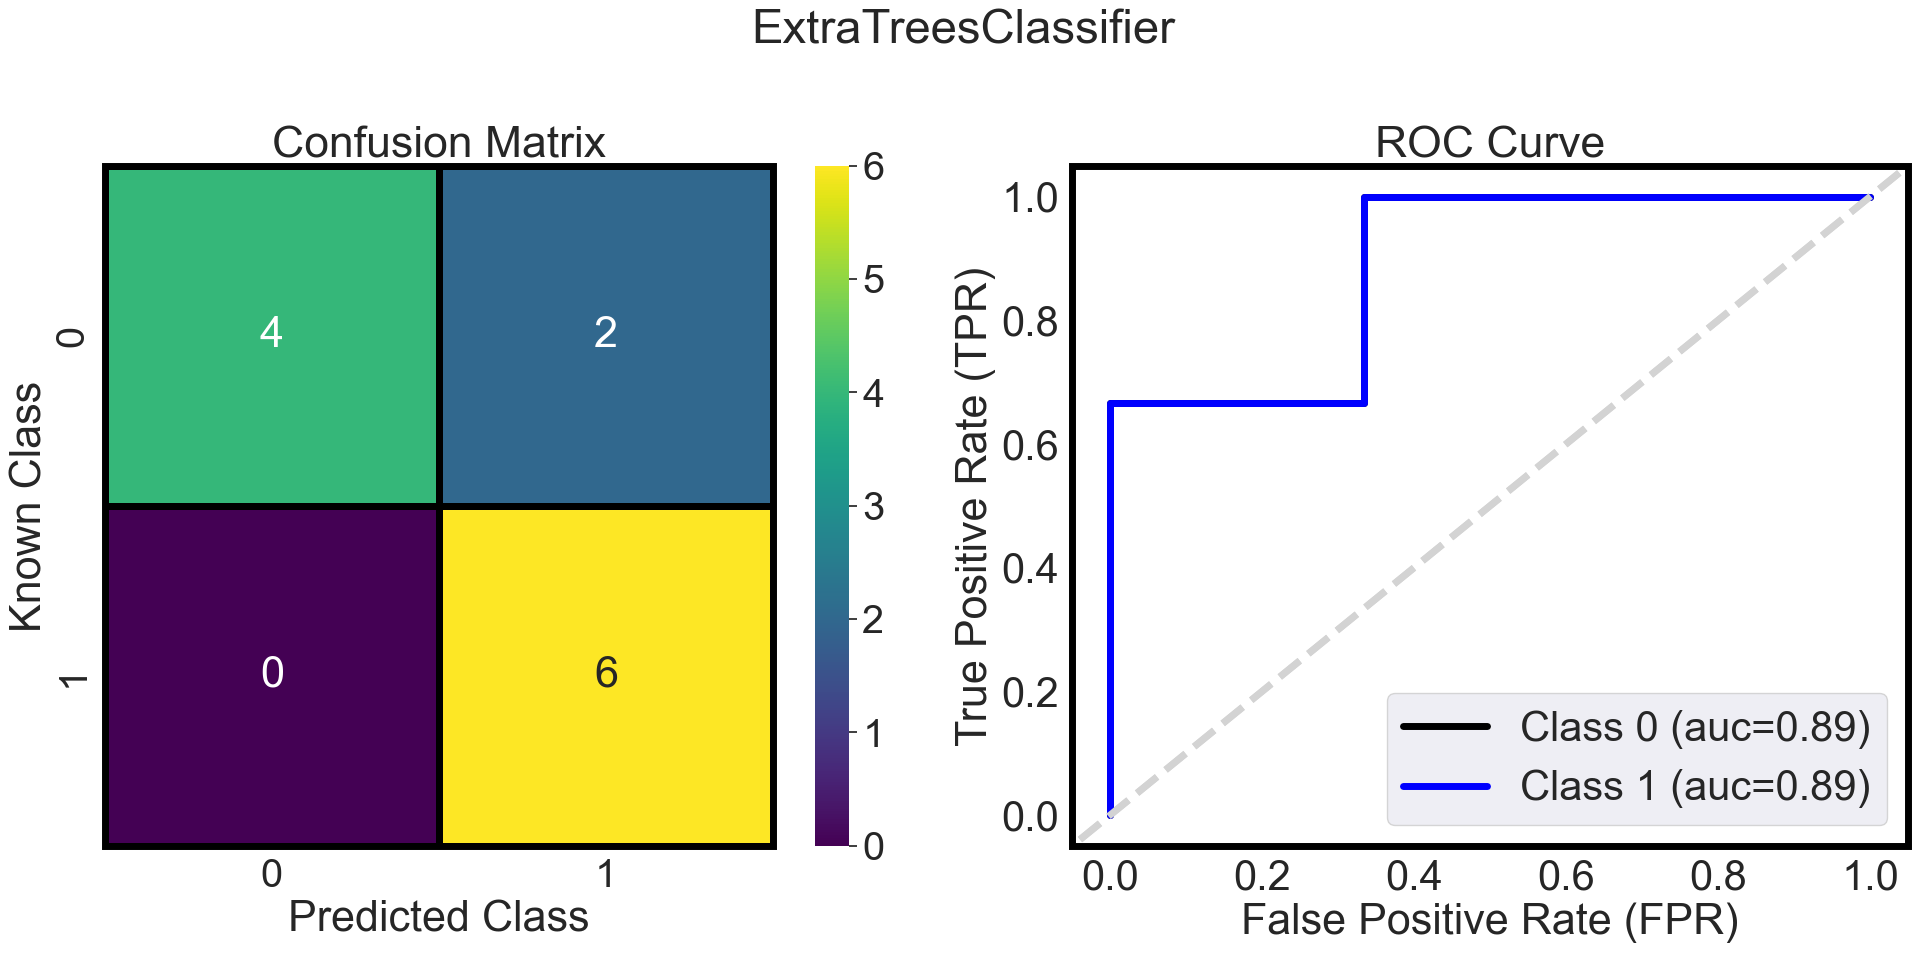

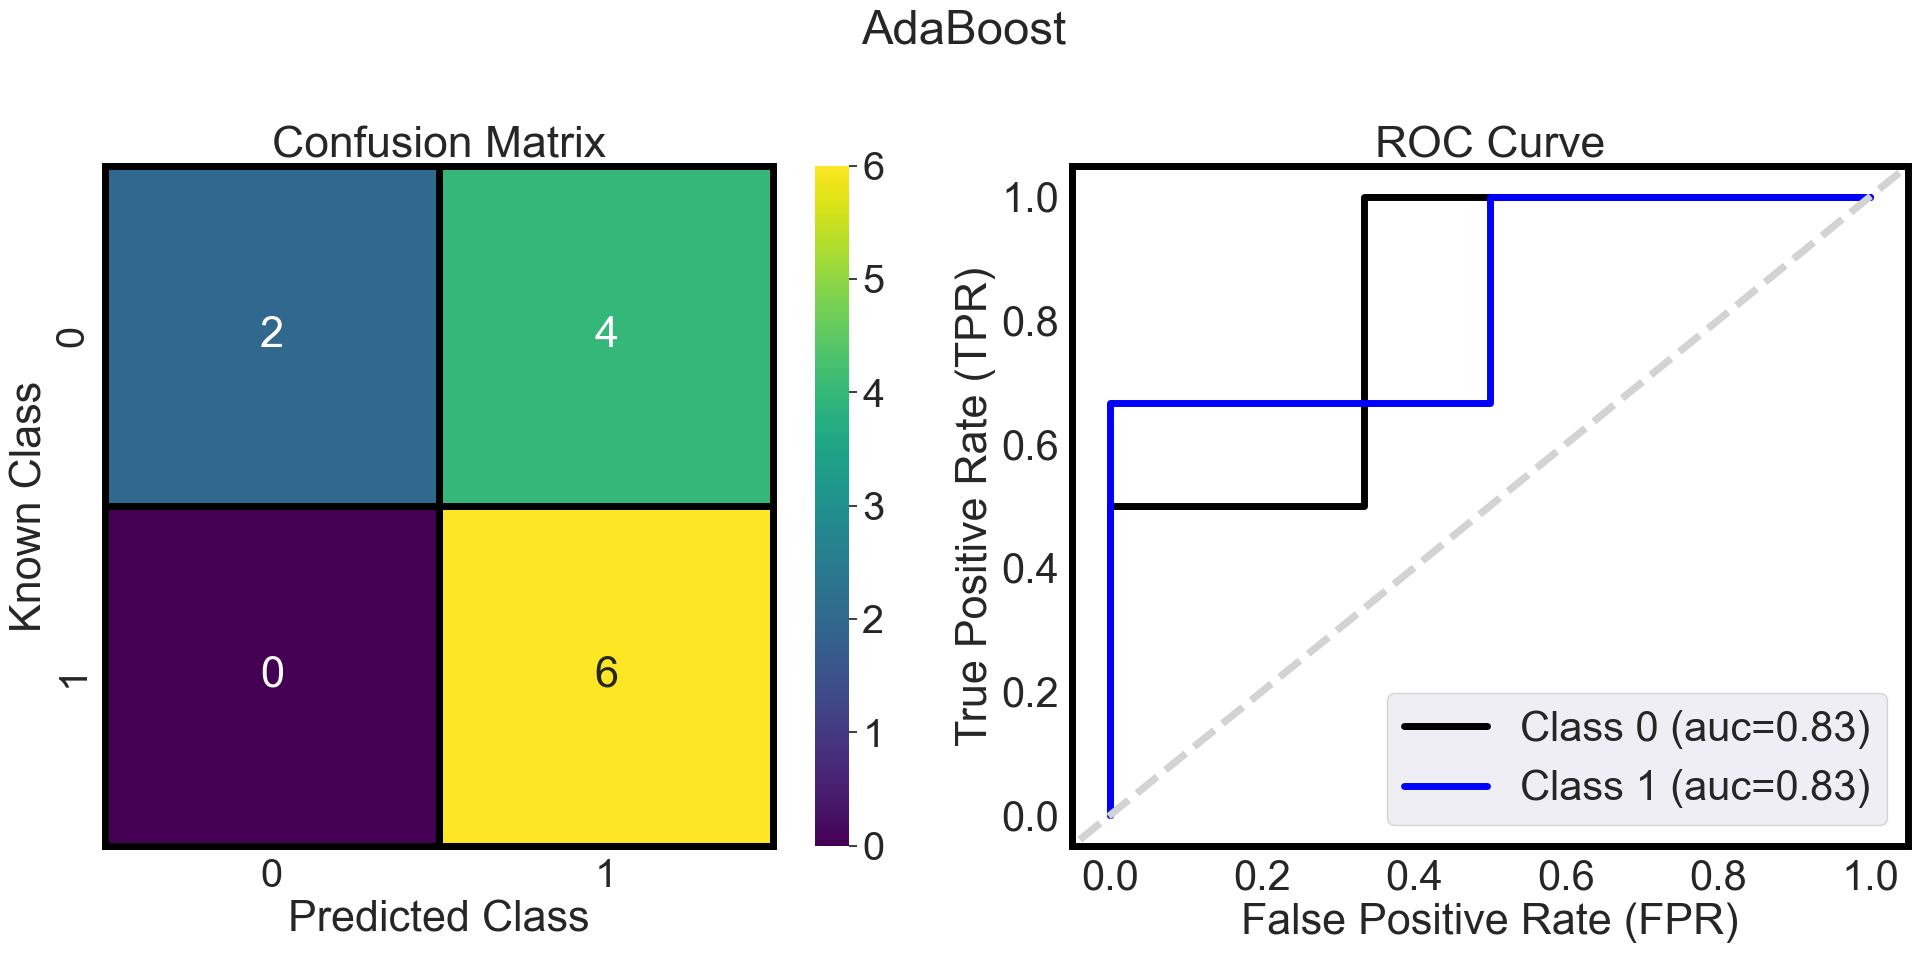

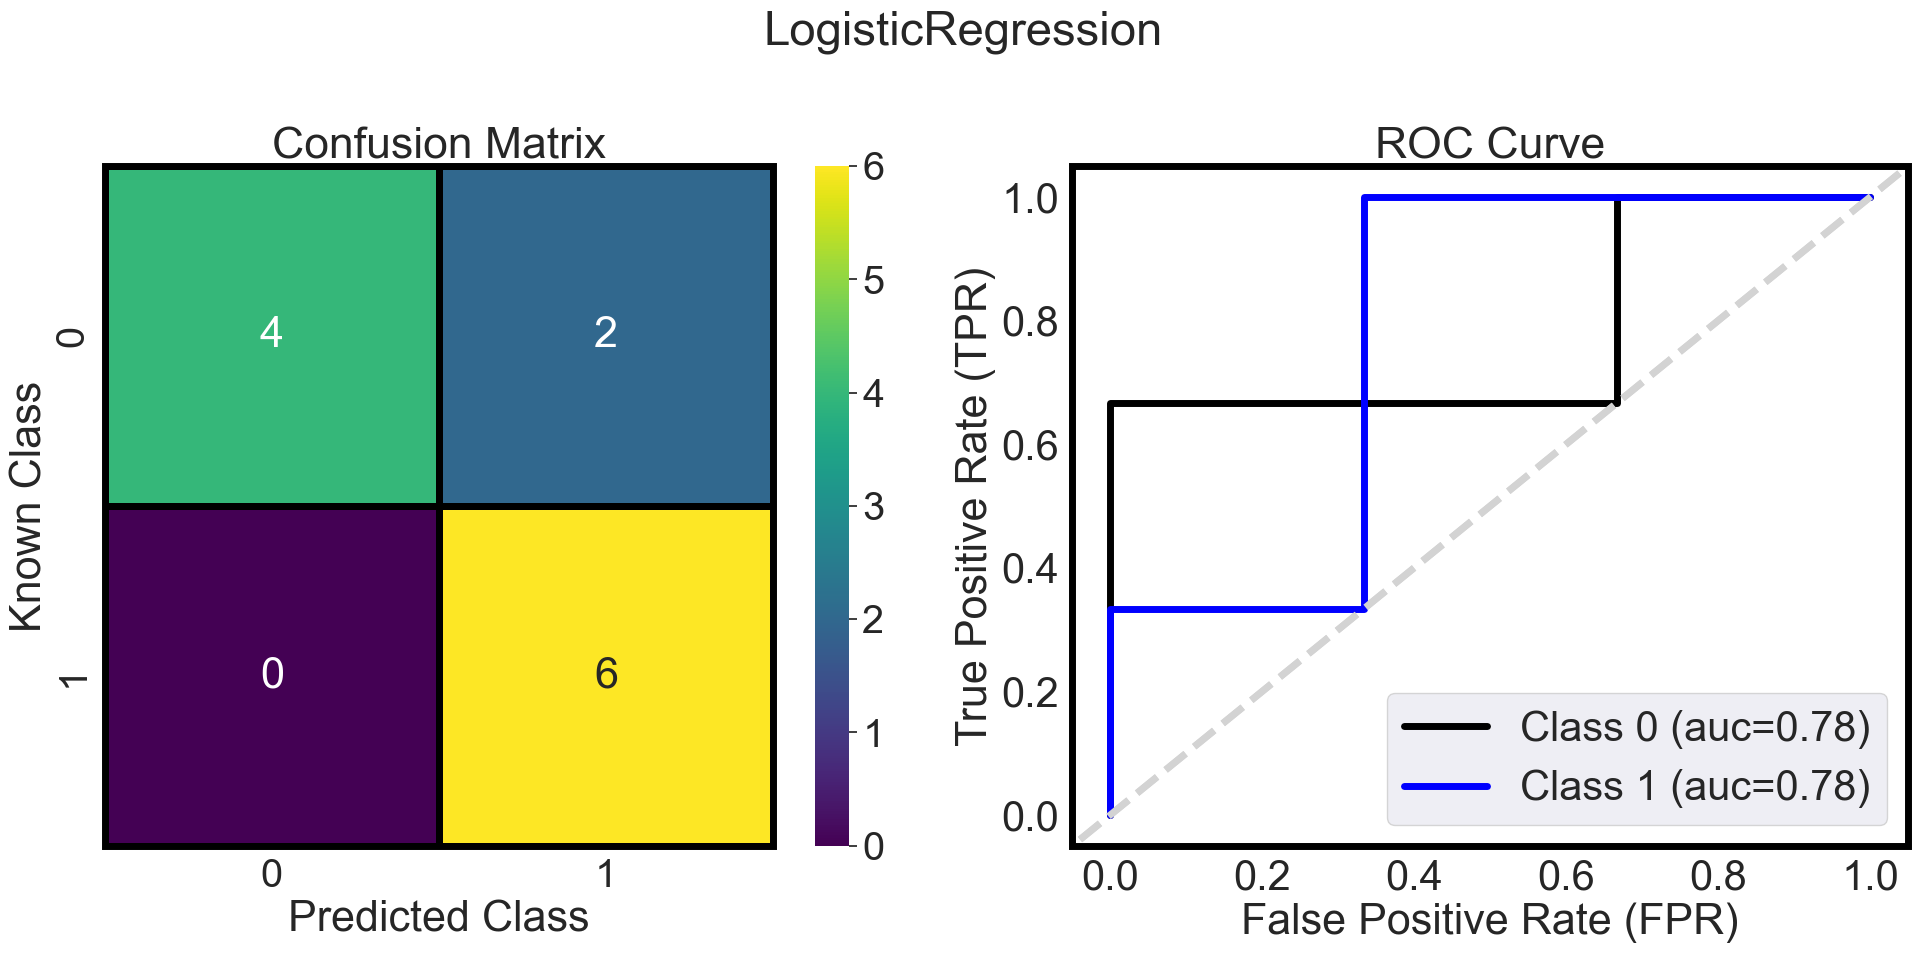

In [93]:
files_plt = []

kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier", "AdaBoost",
         "LogisticRegression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = wf.build_data_from_directory(dirname, max_folds=1)
    
#     log.debug("Last value in the data frame: {}".format(data[165:166]))
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_morderd.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_mordred.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
log.info(df_metrics_for_paper.to_latex())

In [94]:
for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = wf.build_data_from_directory(dirname, max_folds=1)
    wf.which_are_misclassified(data, known_column_label="known", predicted_column_label="prediction", return_indx=False)


NearestNeighbors
-------------

Reading 0.csv
         known  prediction     prob0     prob1
m_index                                       
0          1.0         1.0  0.111111  0.888889
1          0.0         1.0  0.111111  0.888889
2          1.0         1.0  0.111111  0.888889
3          0.0         0.0  1.000000  0.000000
4          1.0         1.0  0.222222  0.777778
5          0.0         0.0  1.000000  0.000000
6          1.0         1.0  0.444444  0.555556
7          0.0         1.0  0.111111  0.888889
8          0.0         0.0  1.000000  0.000000
9          1.0         1.0  0.000000  1.000000
10         0.0         0.0  0.777778  0.222222
11         1.0         1.0  0.222222  0.777778

GaussianProcess
-------------

Reading 0.csv
         known  prediction     prob0     prob1
m_index                                       
0          1.0         1.0  0.119181  0.880819
1          0.0         1.0  0.487049  0.512951
2          1.0         1.0  0.377227  0.622773
3          0.0